### Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
tf.__version__

'2.15.0'

### Load and Preprocess Dataset

In [ ]:
(X_train, y_train) , (_,_)= tf.keras.datasets.mnist.load_data() # tf.keras.datasets.fashion_mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
y_train.shape

(60000,)

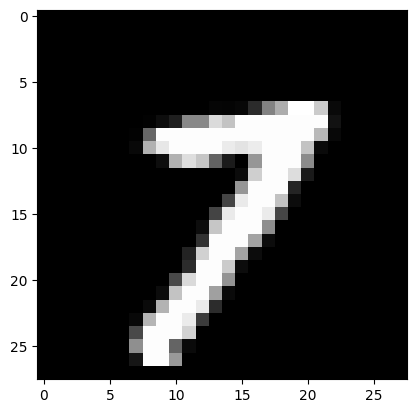

In [ ]:
plt.imshow(X_train[40000], cmap='gray')

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28,28,1).astype('float32') # 1 for black-white
print(X_train.shape)

(60000, 28, 28, 1)


In [ ]:
print('Min:', X_train[0].min(), ' Max', X_train[0].max())

Min: 0.0  Max 255.0


NORMALIZE THE DATA

In [ ]:
X_train = (X_train - 127.5) / 127.5

In [ ]:
print('Min:', X_train[0].min(), ' Max', X_train[0].max())

Min: -1.0  Max 1.0


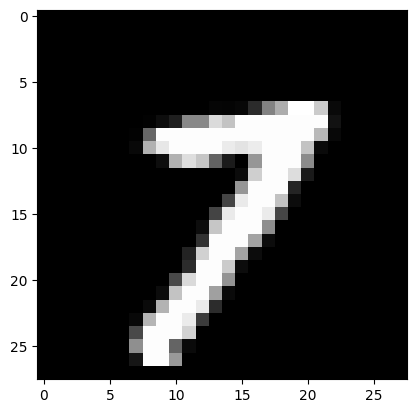

In [ ]:
plt.imshow(X_train[40000], cmap='gray')

In [ ]:
buffer_size = 60000
batch_size = 256

In [ ]:
buffer_size / batch_size

234.375

In [ ]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

### BUILD THE GENERATOR

In [ ]:
def build_generator():
  generator = tf.keras.Sequential()

  generator.add(tf.keras.Input(shape = (100))) # noisy data
  generator.add(layers.Dense(units = 7*7*256, use_bias= False)) # 7*7*256 = 12544, bias units is not necessary generator is not a completely CNN trainer.
  generator.add(layers.BatchNormalization())
  generator.add(layers.LeakyReLU())

  generator.add(layers.Reshape((7,7,256)))

  # 7 * 7 * 128
  generator.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding = 'same', use_bias = False))
  generator.add(layers.BatchNormalization())
  generator.add(layers.LeakyReLU())
  # 14 * 14 * 64
  generator.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias = False))
  generator.add(layers.BatchNormalization())
  generator.add(layers.LeakyReLU())

  # 28 * 28 * 1
  generator.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias = False, activation = 'tanh'))
  generator.summary()

  return generator

In [ ]:
generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

In [ ]:
generator.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'input_1')>

In [ ]:
noise = tf.random.normal([1, 100])
print(noise)

tf.Tensor(
[[ 1.3406403e+00  5.9172288e-02 -4.7036022e-01  9.8752362e-01
  -4.8809254e-01 -1.2893978e-01 -1.6050634e-01 -1.0121560e+00
   5.5873746e-01 -1.0727550e-02 -2.1148851e+00 -2.7301857e+00
  -2.5020323e+00 -1.7787964e+00 -1.8994998e-02 -6.1403912e-01
   1.6713989e+00 -3.9816712e-04 -9.8599213e-01  2.2634174e-01
  -1.3086447e+00  1.6026305e+00  9.7650367e-01  1.3478572e+00
   2.4054195e-01  7.9897203e-02 -1.3337901e+00  6.5633780e-01
   8.0013269e-01  6.8285936e-01  1.4405432e+00 -1.0302930e+00
  -6.5701163e-01 -5.6798100e-01  6.0918456e-01 -1.3197197e+00
  -1.0031389e+00  1.4877523e+00 -2.1437752e+00 -1.1865960e+00
   8.5959846e-01  3.9695182e+00  7.6473528e-01 -9.8452228e-01
  -2.1465390e+00  2.0266907e-02 -8.6630630e-01 -5.7005823e-01
   2.1073458e+00  1.4752003e+00 -1.0197996e+00  6.6109657e-01
   8.2836586e-01 -8.6325127e-01  7.5611585e-01  1.2386959e+00
   8.0809522e-01  2.0247522e-01  1.0095069e+00  5.8278102e-01
   2.1034141e+00 -6.0964906e-01  7.8213364e-01  4.1726330e-

In [ ]:
type(generator)

keras.src.engine.sequential.Sequential

In [ ]:
generated_image = generator(noise, training = False)

In [ ]:
generated_image.shape

TensorShape([1, 28, 28, 1])

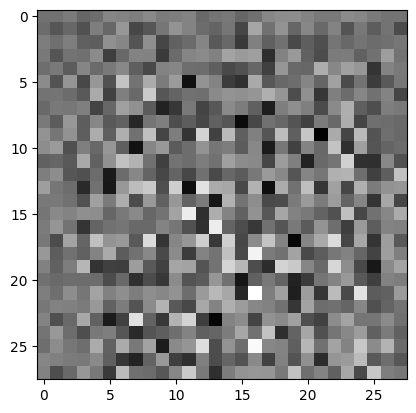

In [ ]:
plt.imshow(generated_image[0, :,:, 0], cmap='gray')

### BUILD THE DISCRIMINATOR

In [ ]:
def build_discriminator():
  discriminator = tf.keras.Sequential()

  generator.add(tf.keras.Input(shape = (28,28,1)))

  # 14 * 14 * 64
  discriminator.add(layers.Conv2D(filters = 64, strides= (2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  discriminator.add(layers.LeakyReLU())
  discriminator.add(layers.Dropout(0.3))


  # 7 * 7 * 128
  discriminator.add(layers.Conv2D(filters = 128, strides= (2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  discriminator.add(layers.LeakyReLU())
  discriminator.add(layers.Dropout(0.3))

  discriminator.add(layers.Flatten())
  discriminator.add(layers.Dense(1))

  discriminator.summary()

  return discriminator

In [ ]:
discriminator = build_discriminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [ ]:
discriminator

In [ ]:
discriminator.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>

In [ ]:
discriminator(generated_image, training =False ) # logits

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00031568]], dtype=float32)>

In [ ]:
tf.sigmoid(-0.00160825)

<tf.Tensor: shape=(), dtype=float32, numpy=0.49959794>

### Error Calculation

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [ ]:
def discriminator_loss(expected_output, fake_output ):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [ ]:
def generator_loss(fake_output ):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)

### TRAINING

In [ ]:
EPOCHS = 100
NOISE_DIMENSION = 100
NUMBER_OF_IMAGES = 16

In [ ]:
@tf.function
def train(images):
  noise = tf.random.normal([batch_size, NOISE_DIMENSION])
  with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
    generated_images = generator(noise, training = True)

    expected_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(expected_output, fake_output)

  generator_gradients = generator_tape.gradient(gen_loss, generator.trainable_variables)
  discriminator_gradients = discriminator_tape.gradient(disc_loss, discriminator.trainable_variables)


  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))



In [ ]:
#tf.config.run_functions_eagerly(True)
#X_train_batch = X_train.as_numpy_iterator().next()
#train(X_train_batch)

In [ ]:
test_images = tf.random.normal([NUMBER_OF_IMAGES, NOISE_DIMENSION])
test_images.shape

TensorShape([16, 100])

In [ ]:
def train_gan(dataset, epochs, test_images):
  for epoch in range(epochs):
    print('Epoch: ', epoch+1)
    for images_batch in dataset:
      tf.config.run_functions_eagerly(True)
      train(images_batch)


    generated_images = generator(test_images, training = False)
    fig = plt.figure(figsize = (10,10))
    for i in range(generated_images.shape[0]):
      plt.subplot(4,4, i+1)
      plt.imshow(generated_images[i,:,:,0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()

Epoch:  1


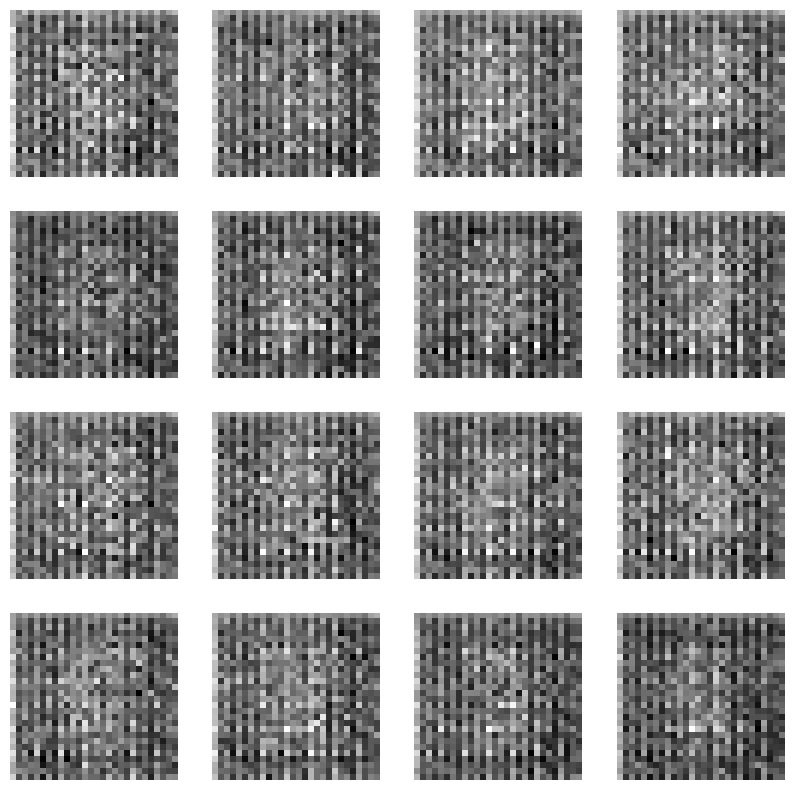

Epoch:  2


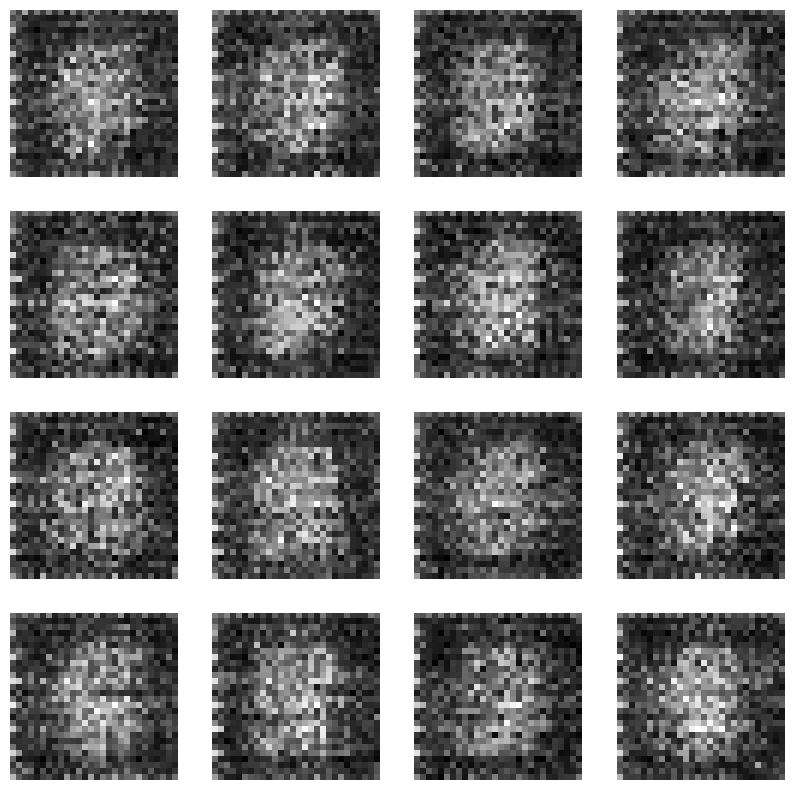

Epoch:  3


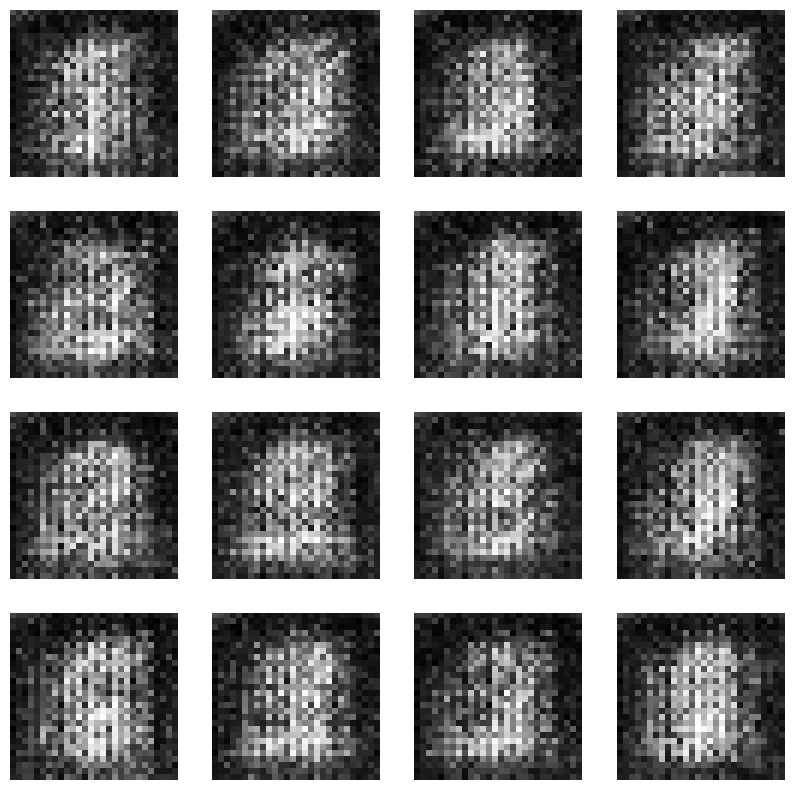

Epoch:  4


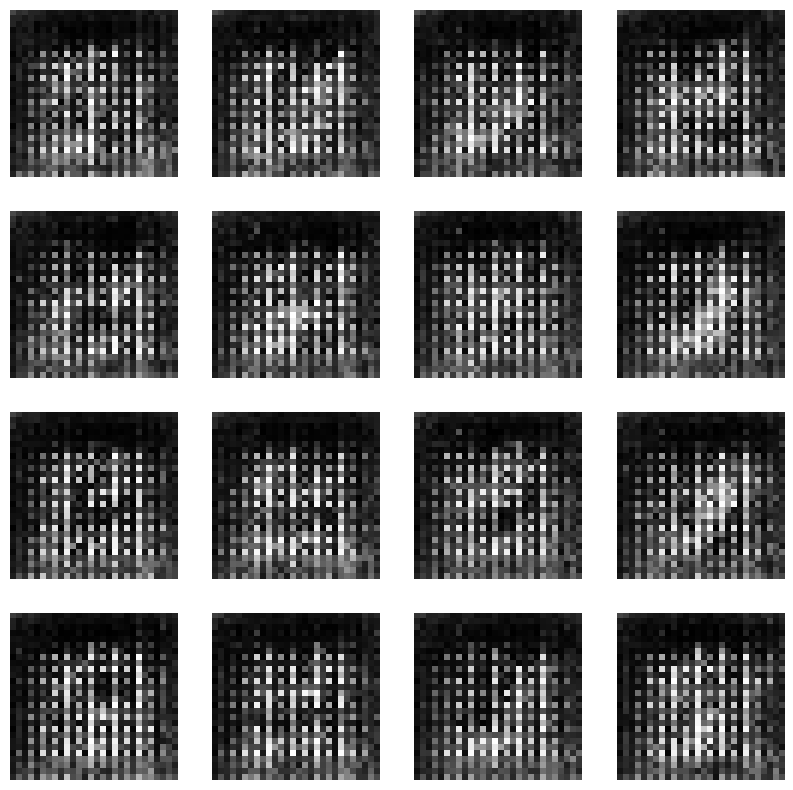

Epoch:  5


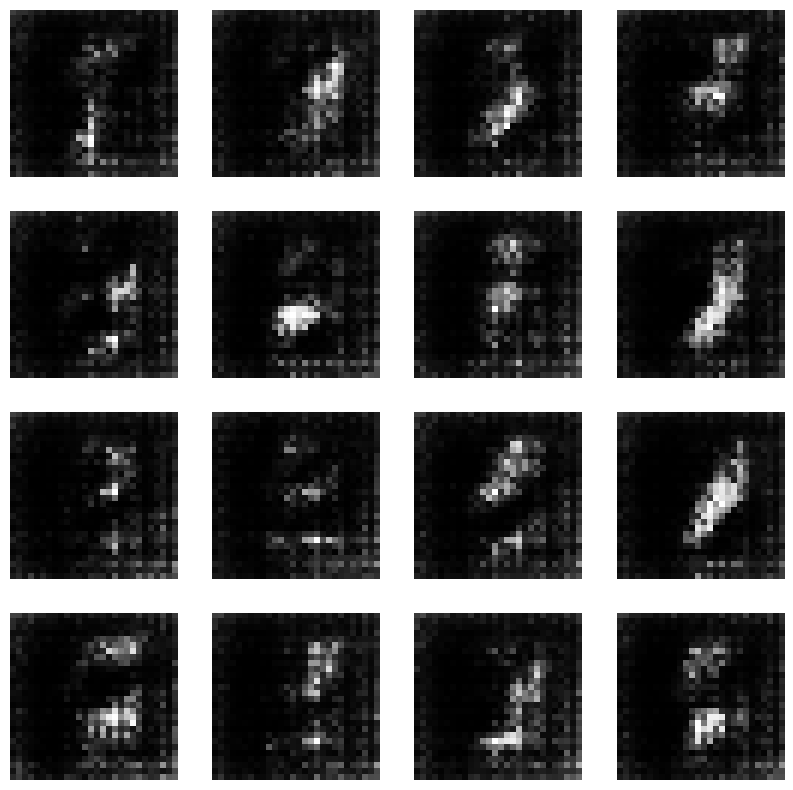

Epoch:  6


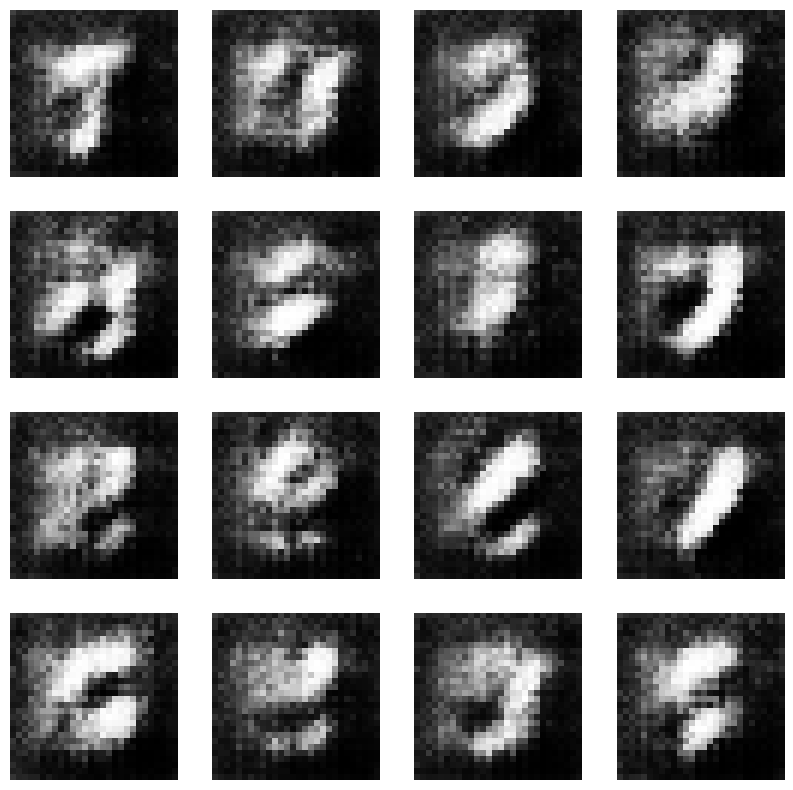

Epoch:  7


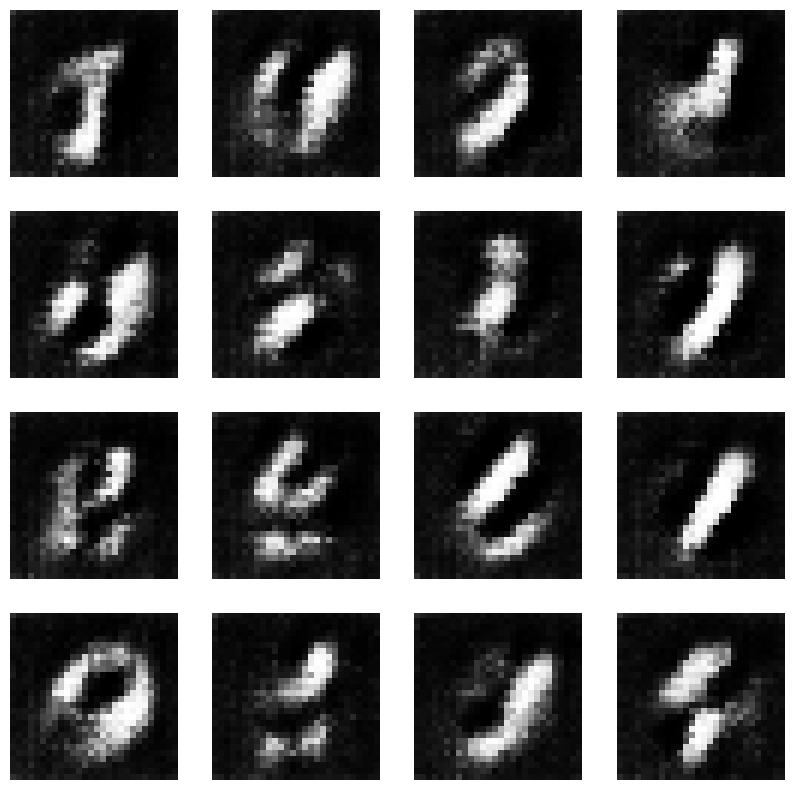

Epoch:  8


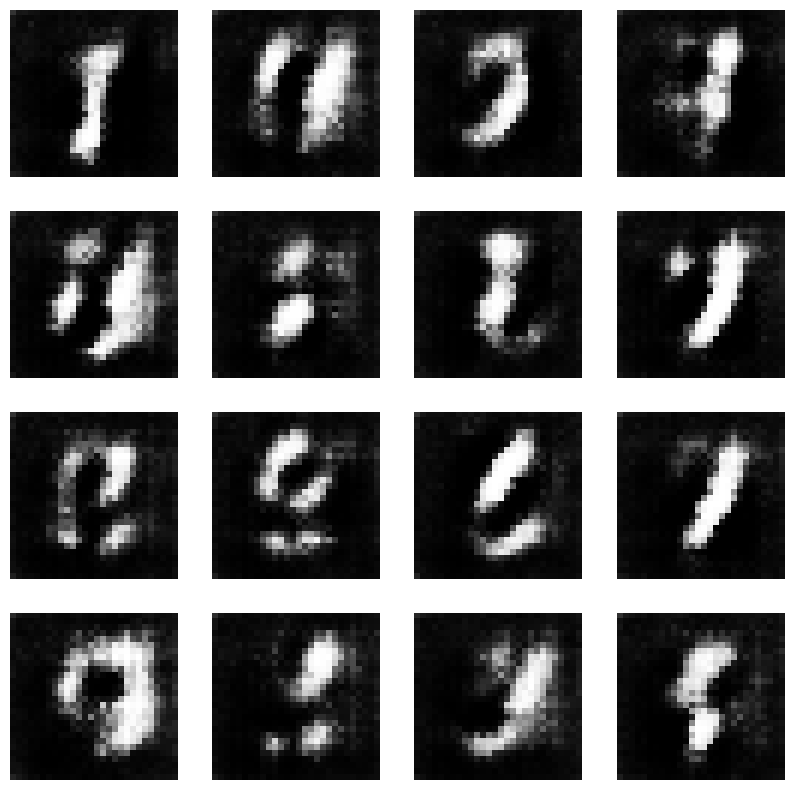

Epoch:  9


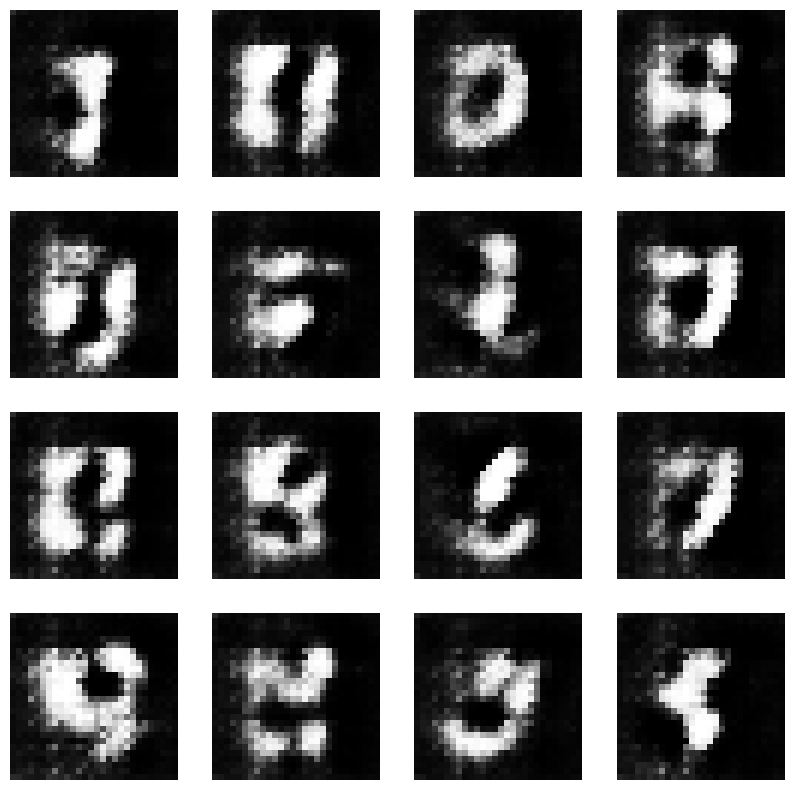

Epoch:  10


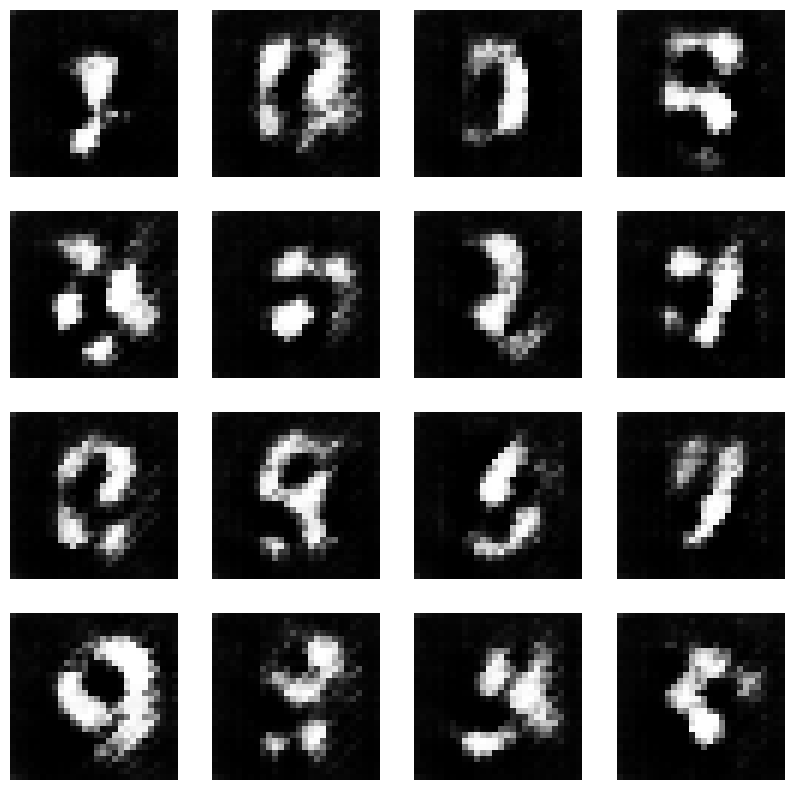

Epoch:  11


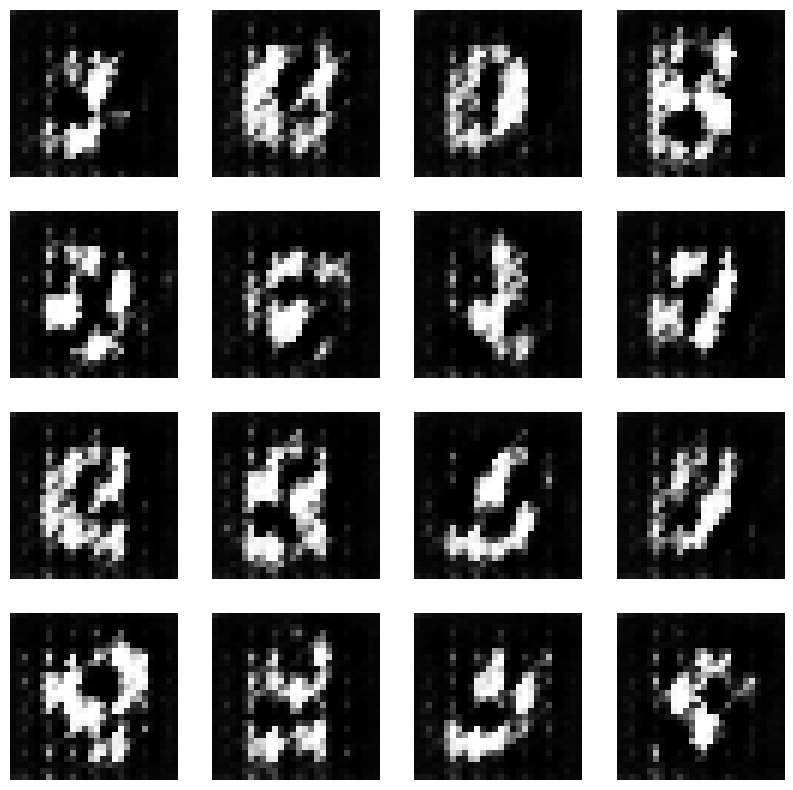

Epoch:  12


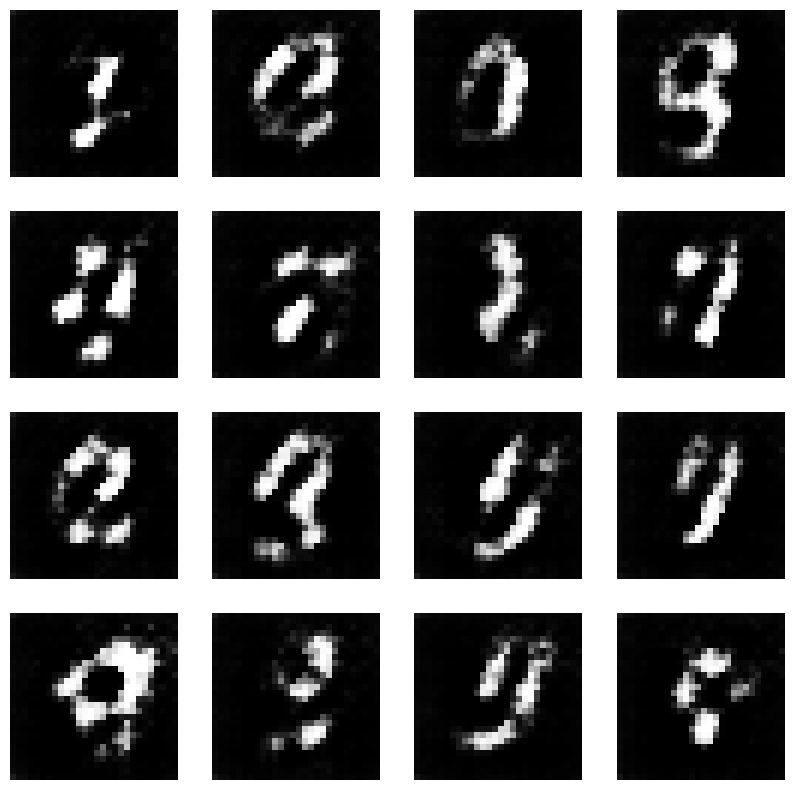

Epoch:  13


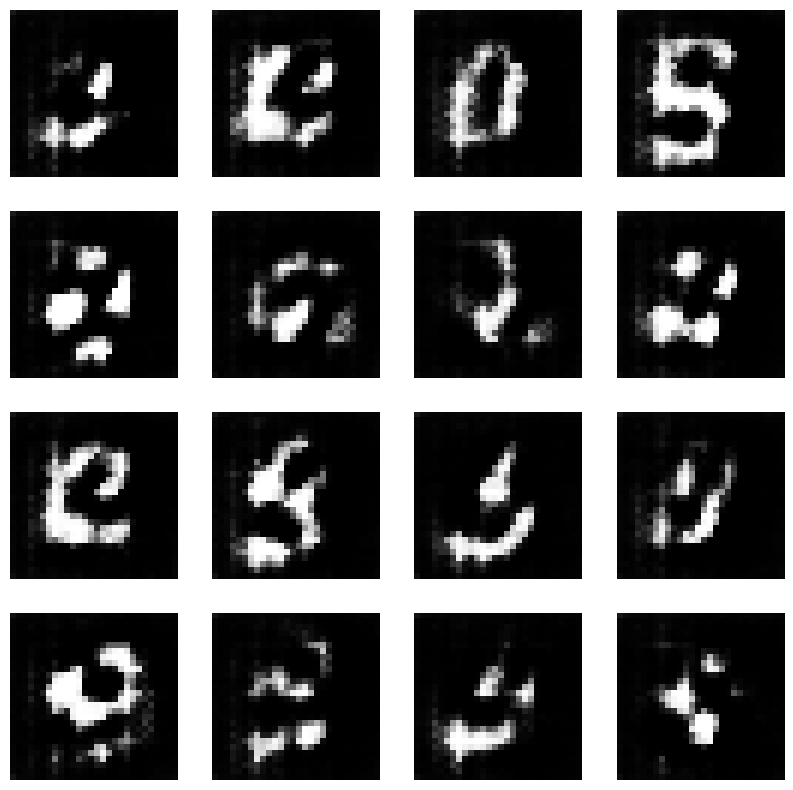

Epoch:  14


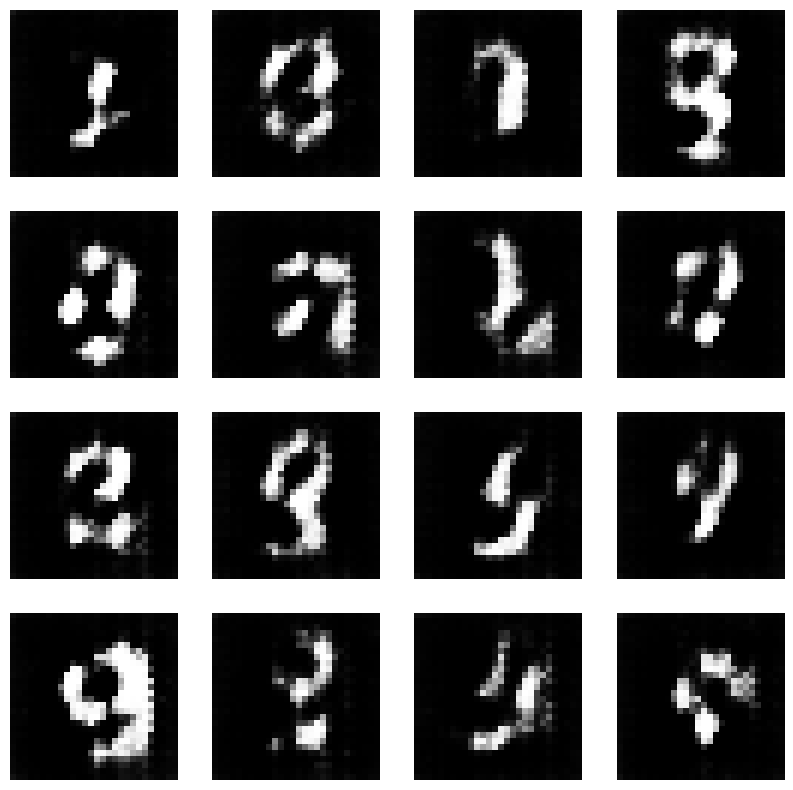

Epoch:  15


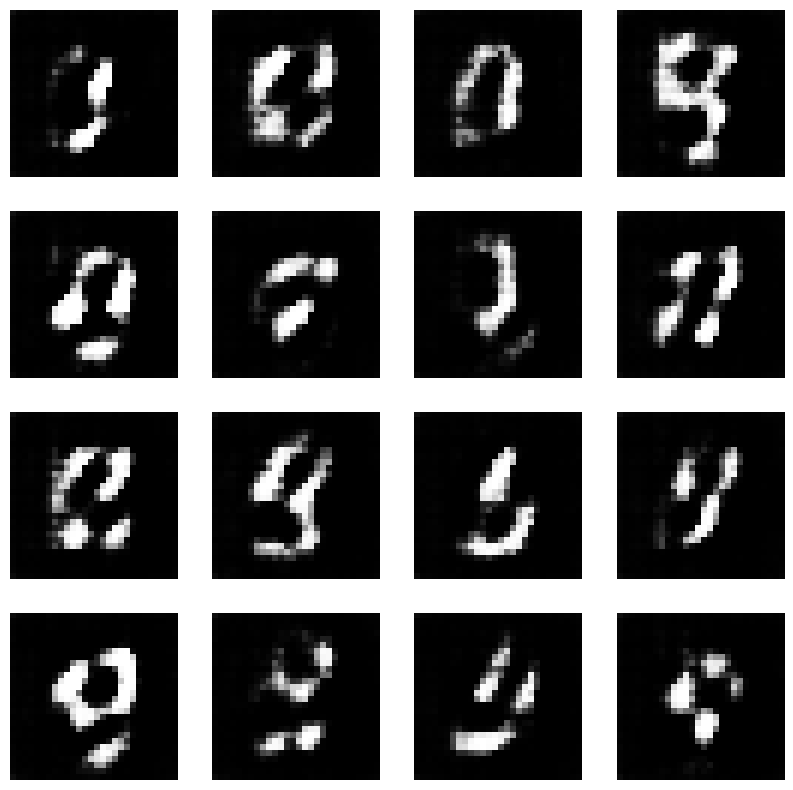

Epoch:  16


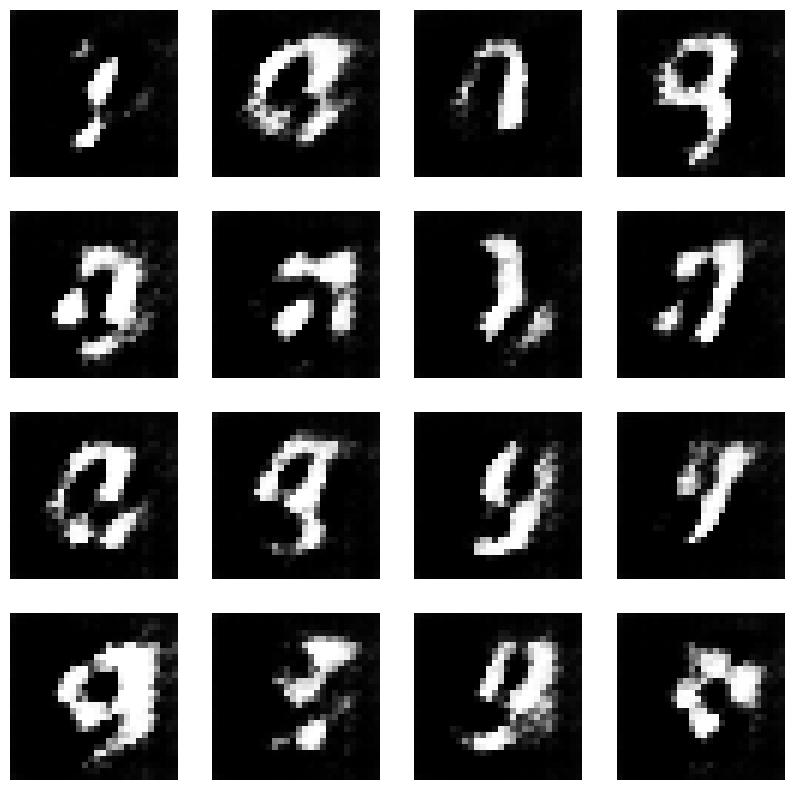

Epoch:  17


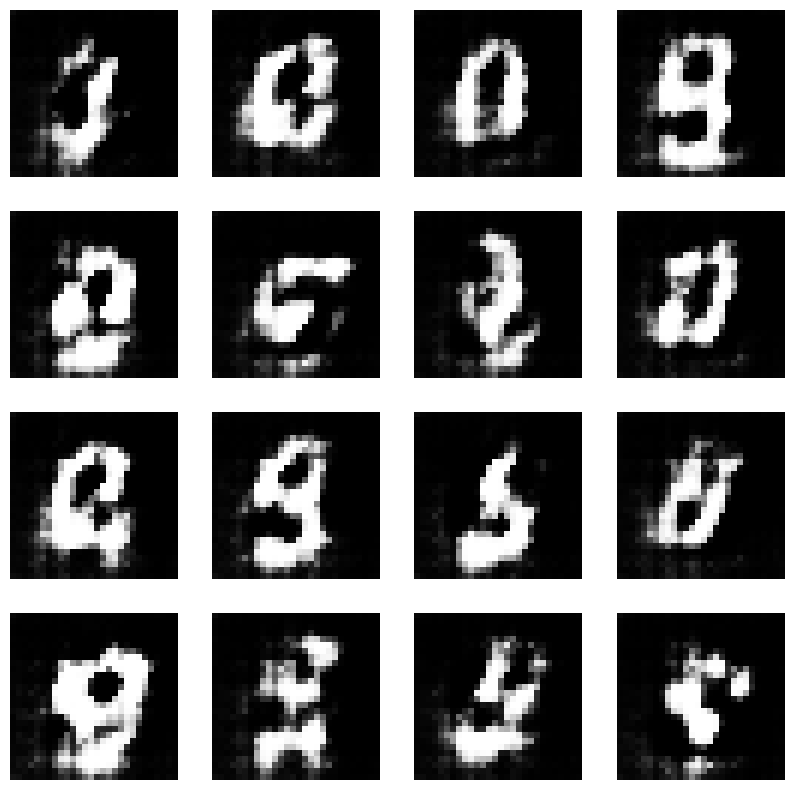

Epoch:  18


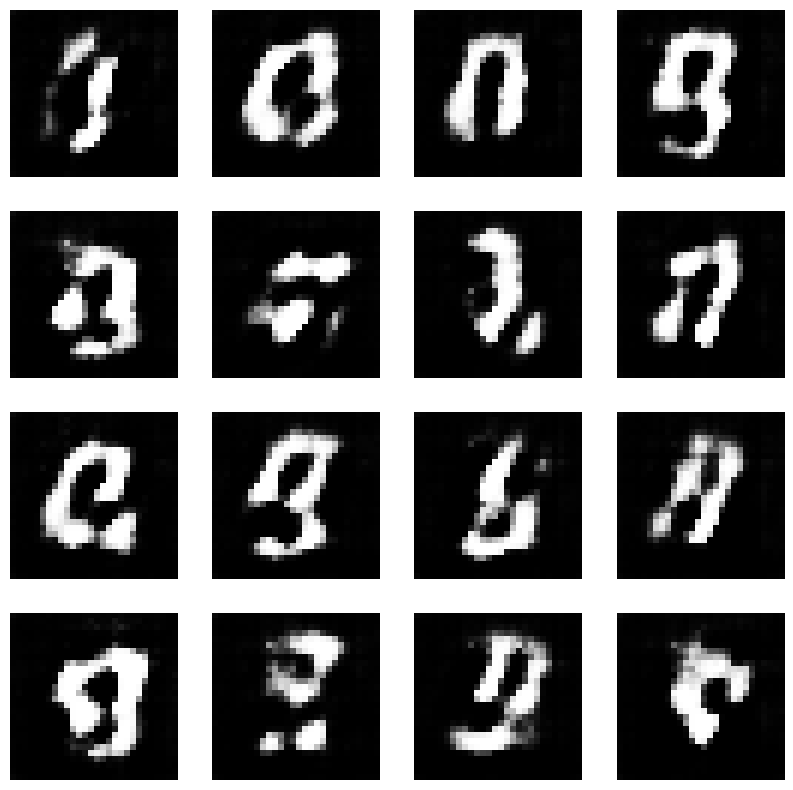

Epoch:  19


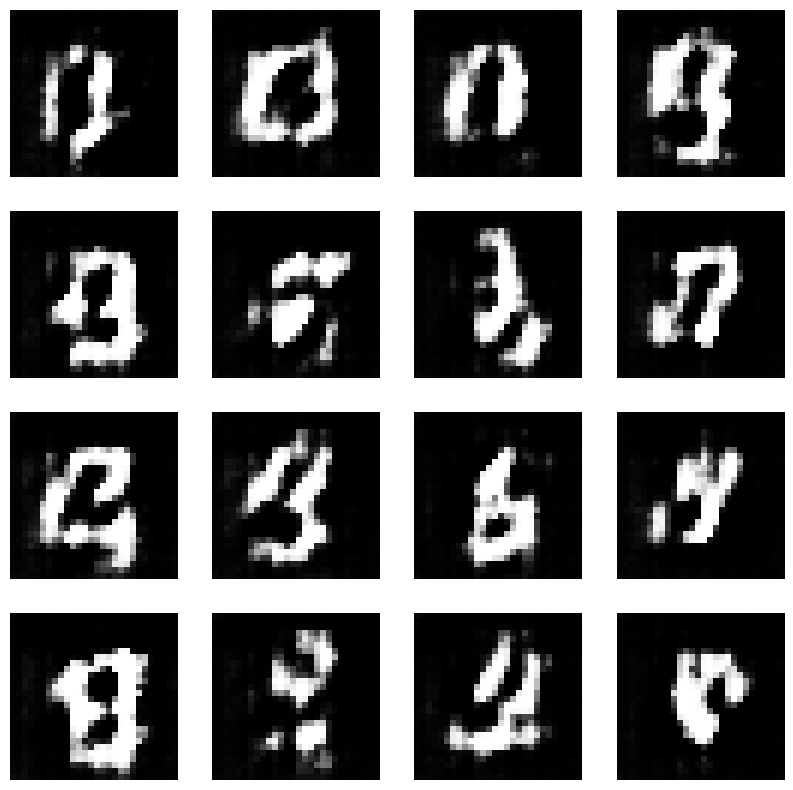

Epoch:  20


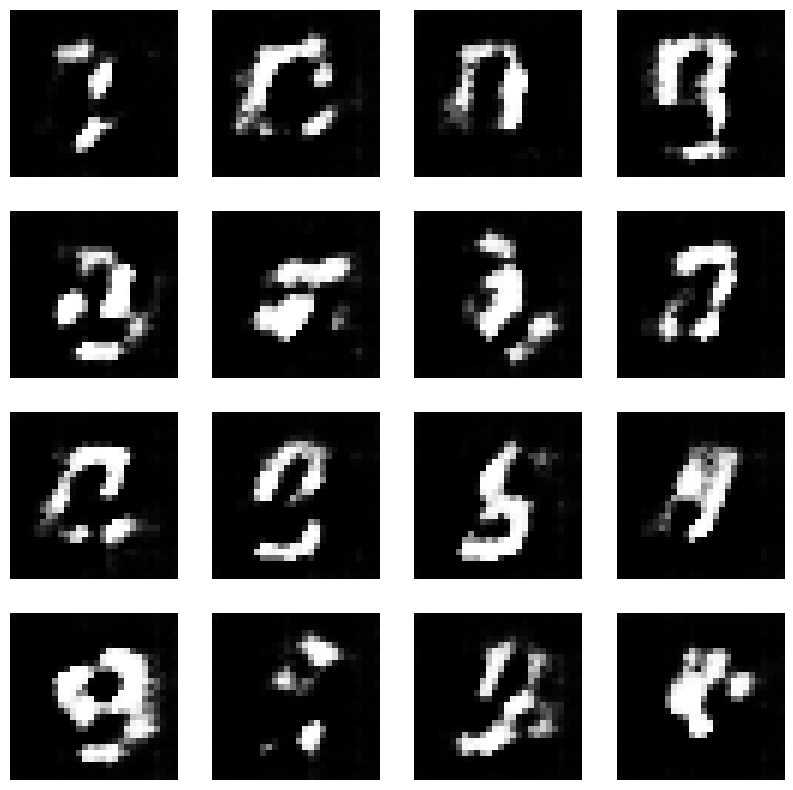

Epoch:  21


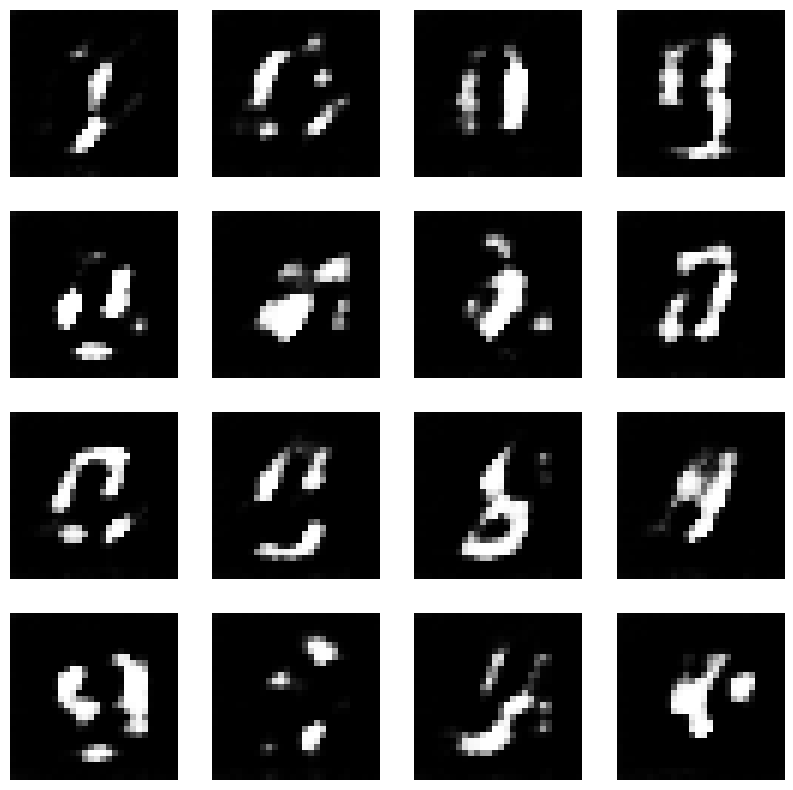

Epoch:  22


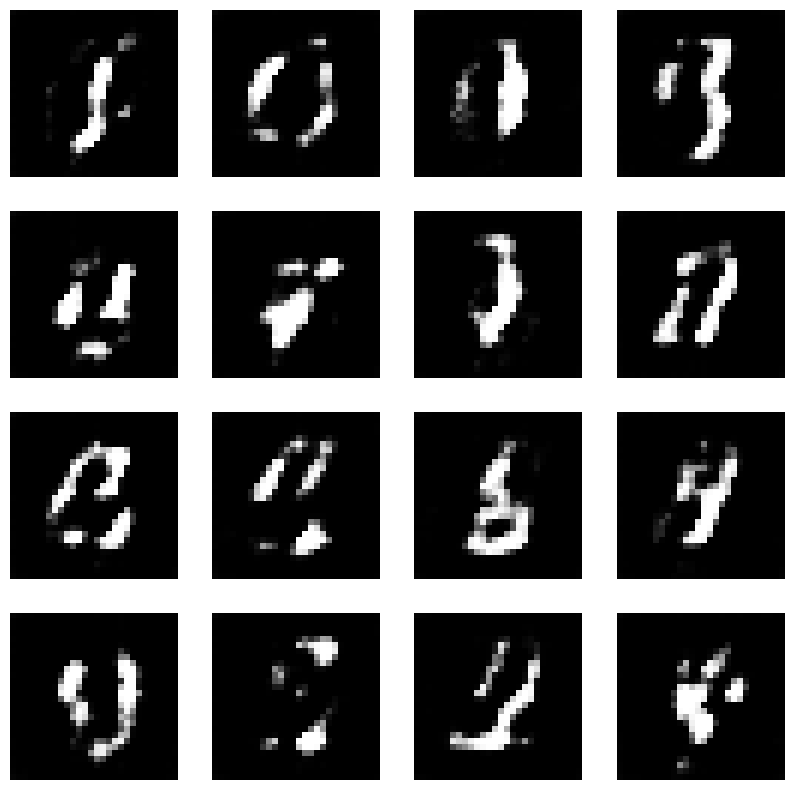

Epoch:  23


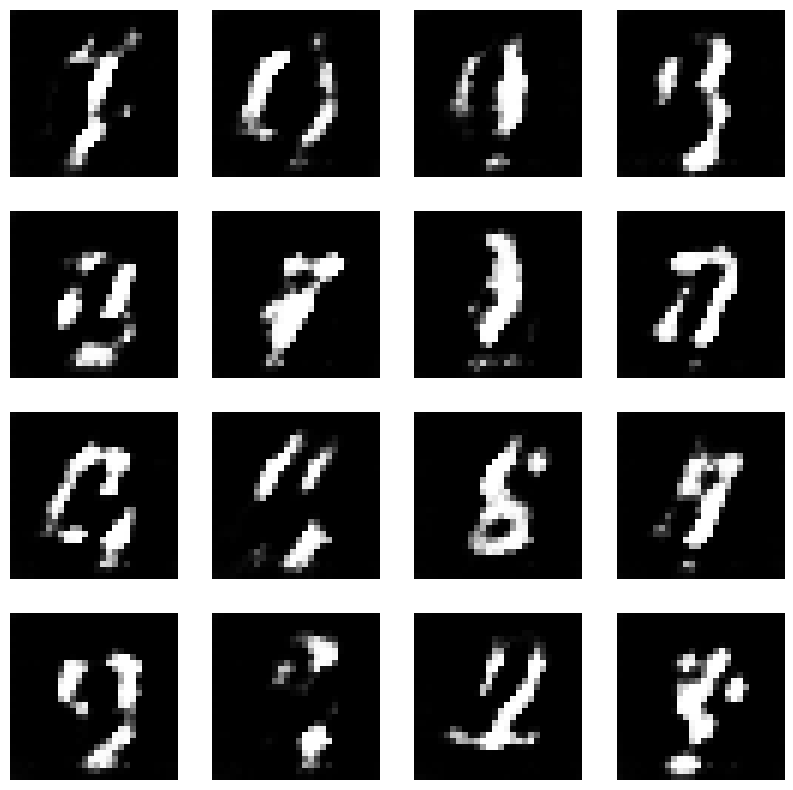

Epoch:  24


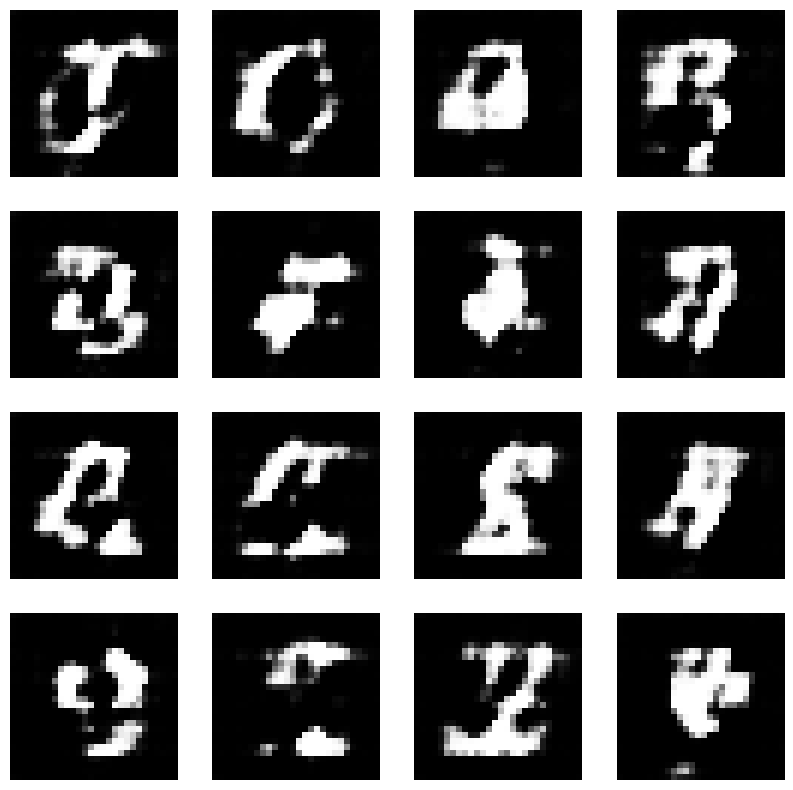

Epoch:  25


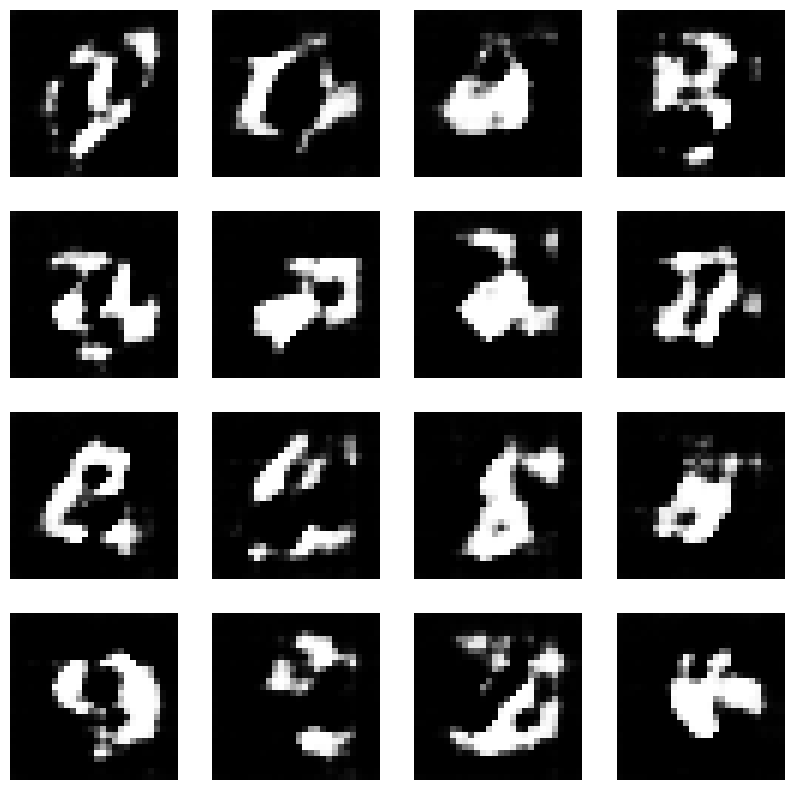

Epoch:  26


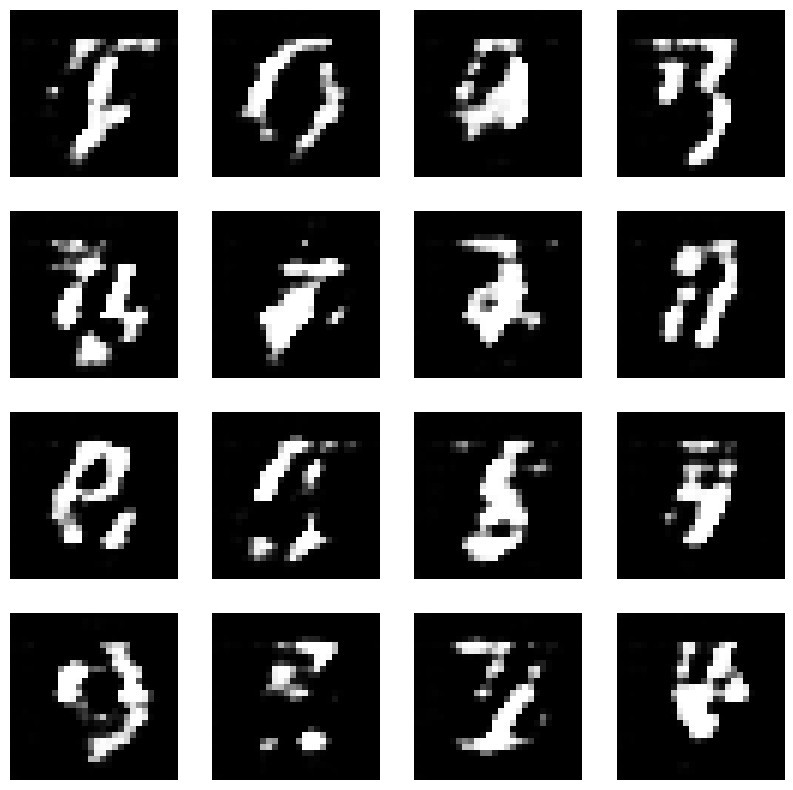

Epoch:  27


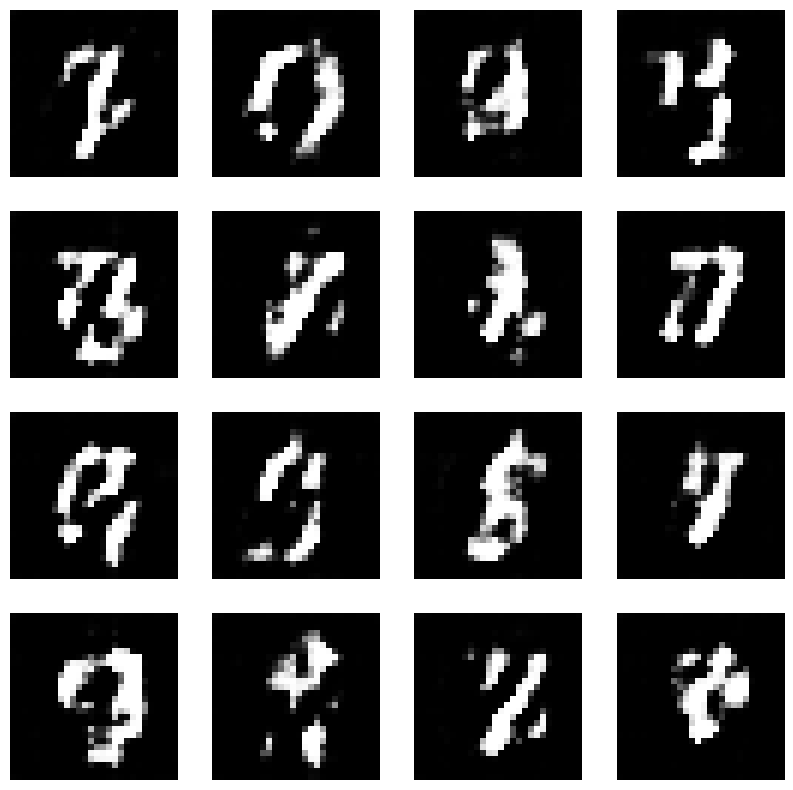

Epoch:  28


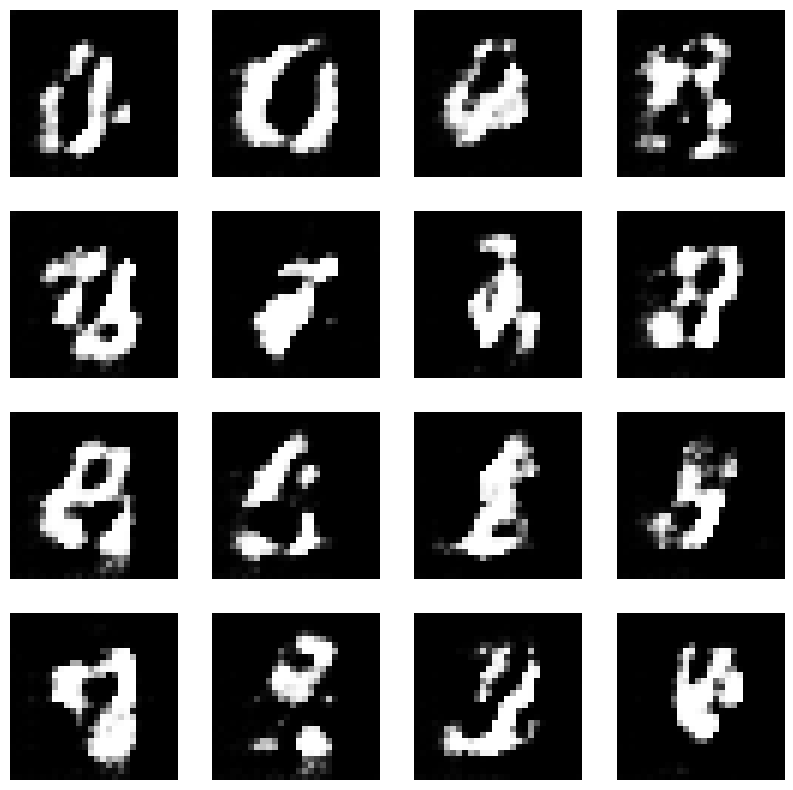

Epoch:  29


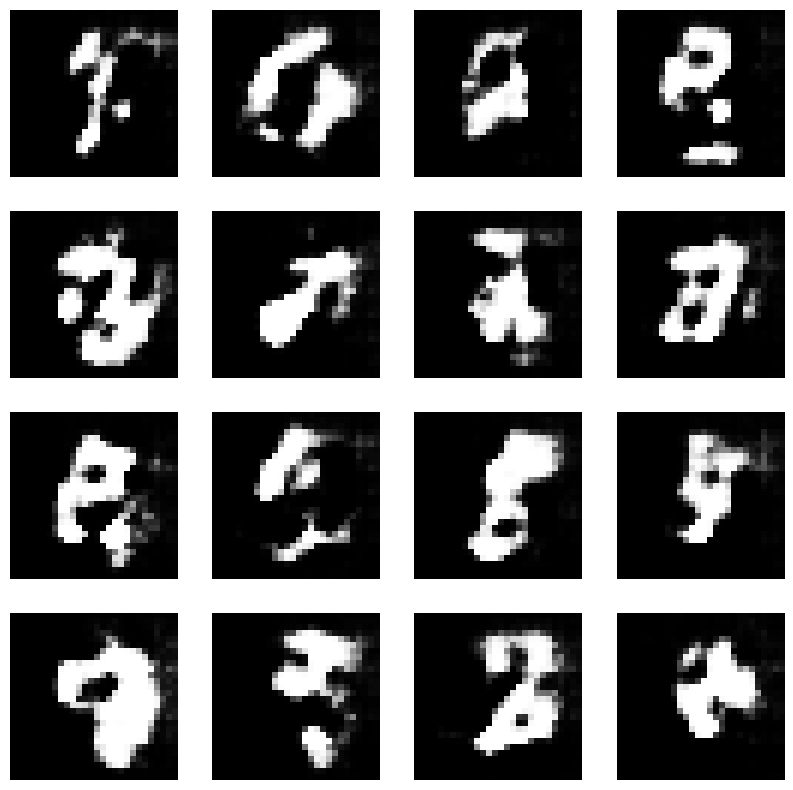

Epoch:  30


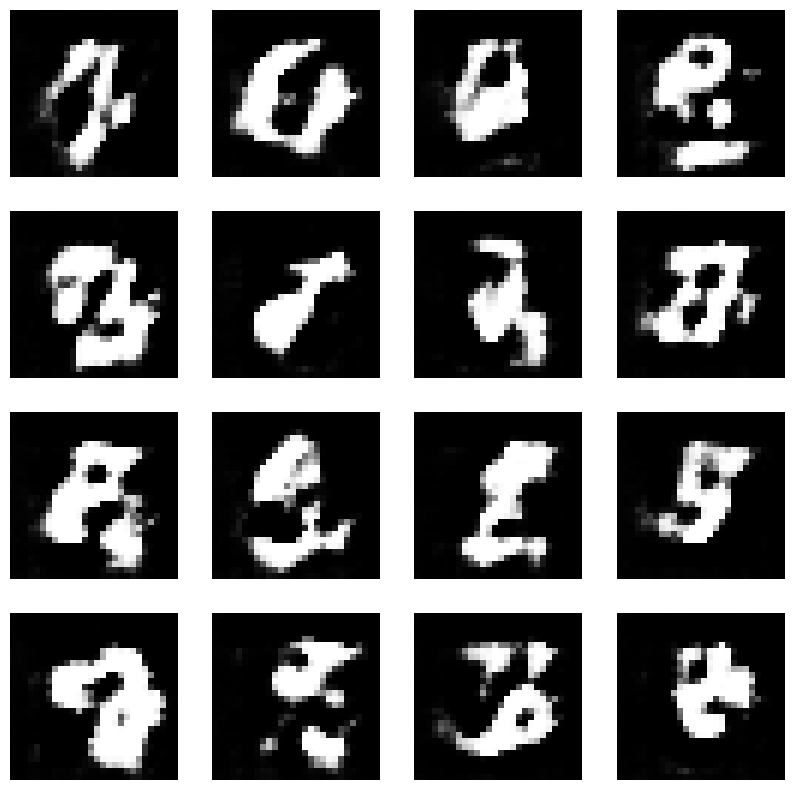

Epoch:  31


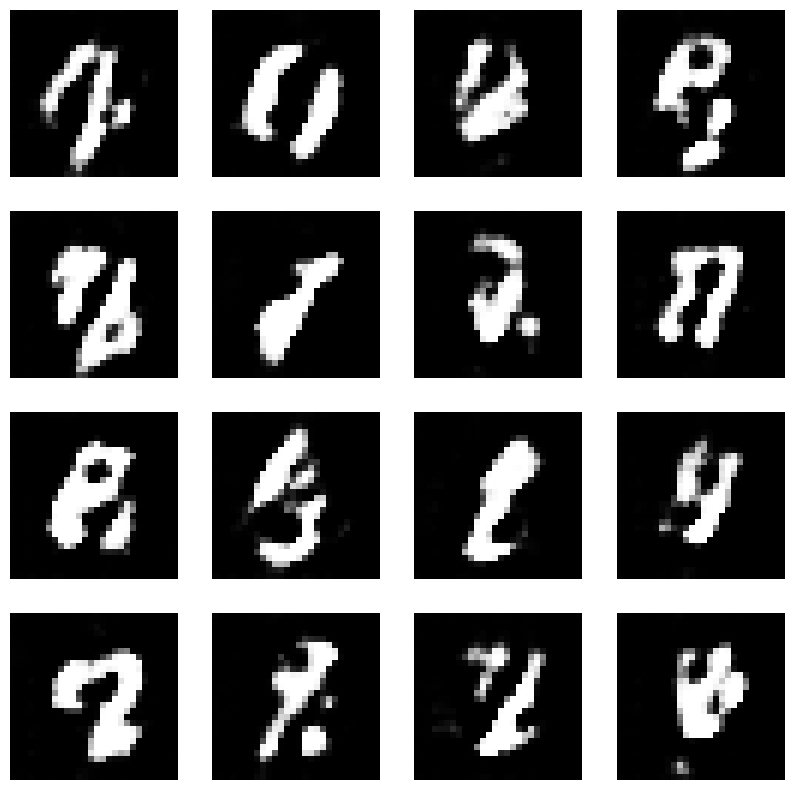

Epoch:  32


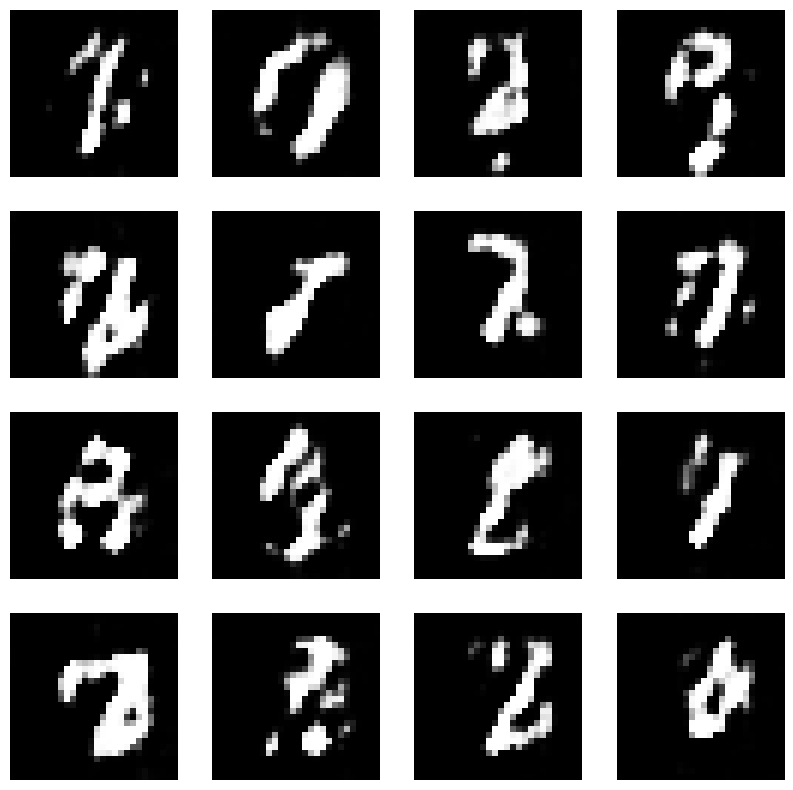

Epoch:  33


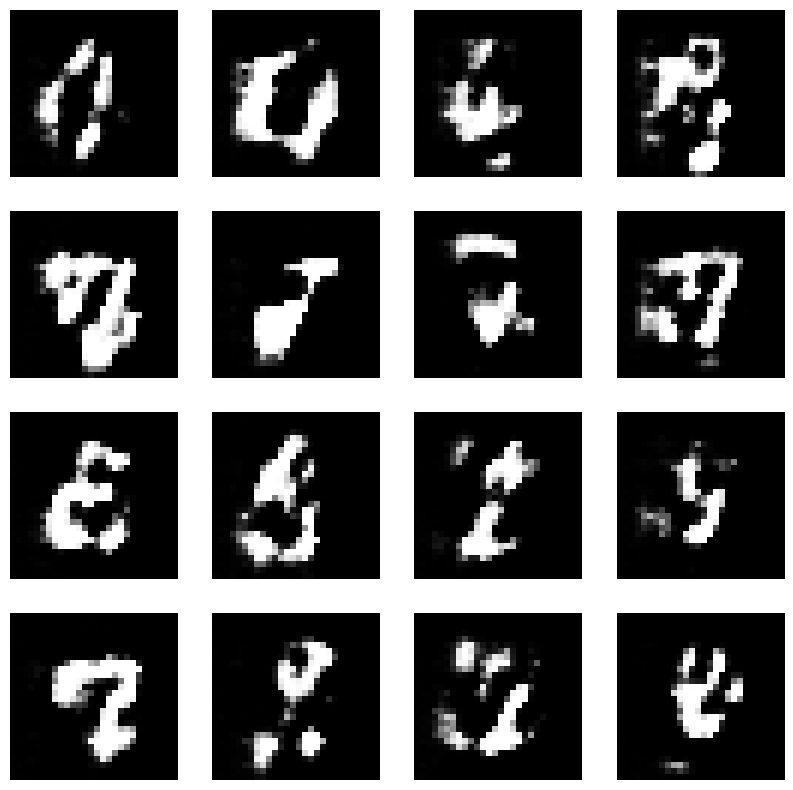

Epoch:  34


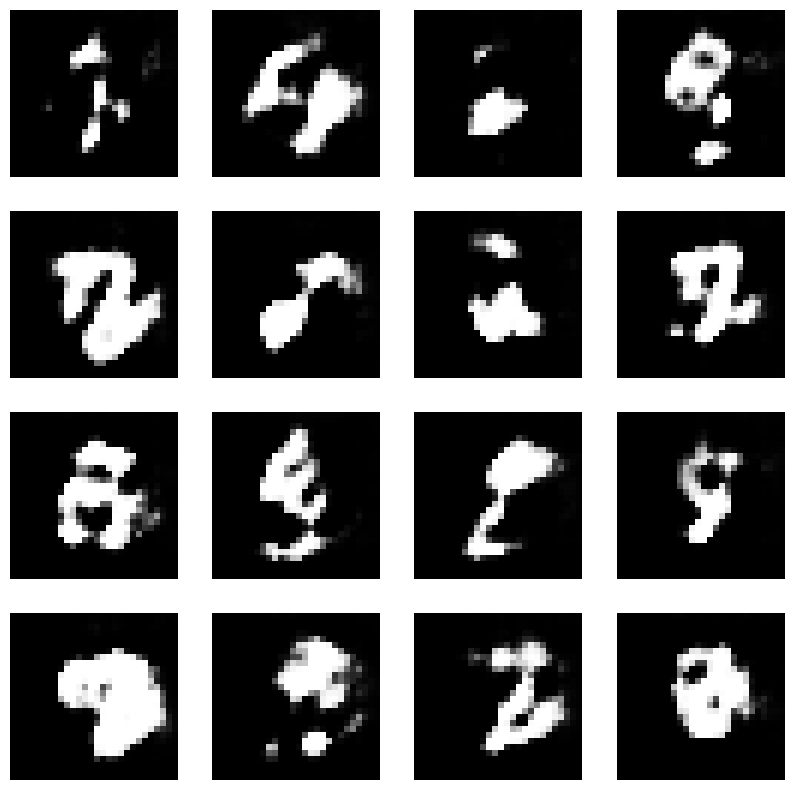

Epoch:  35


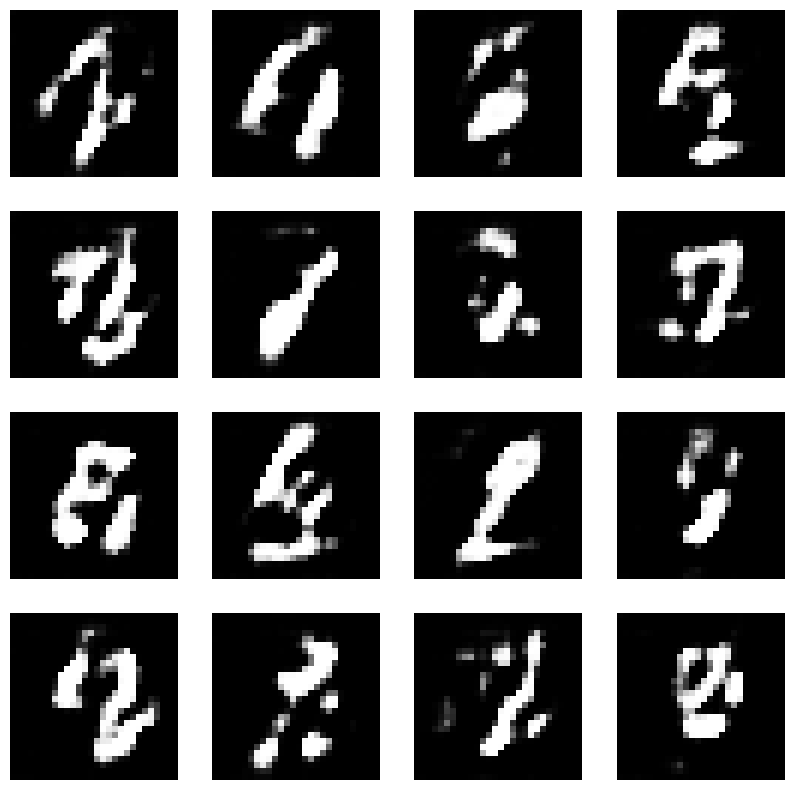

Epoch:  36


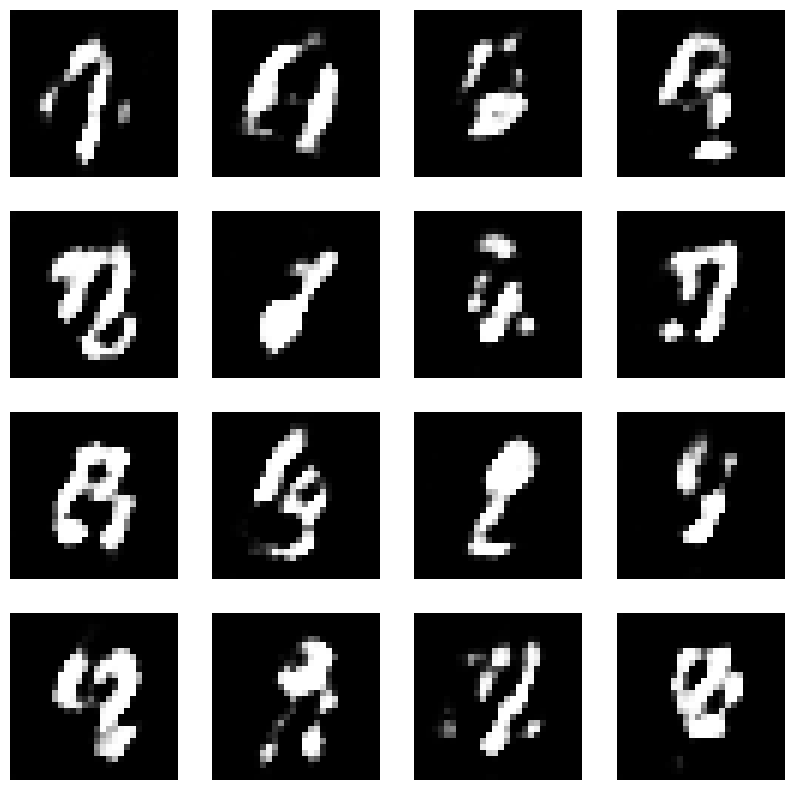

Epoch:  37


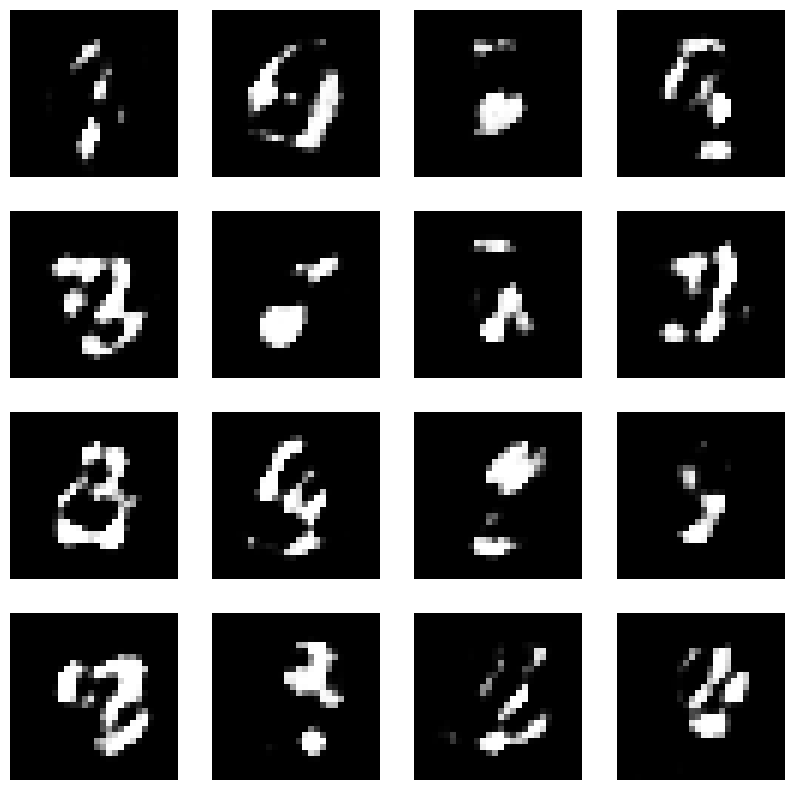

Epoch:  38


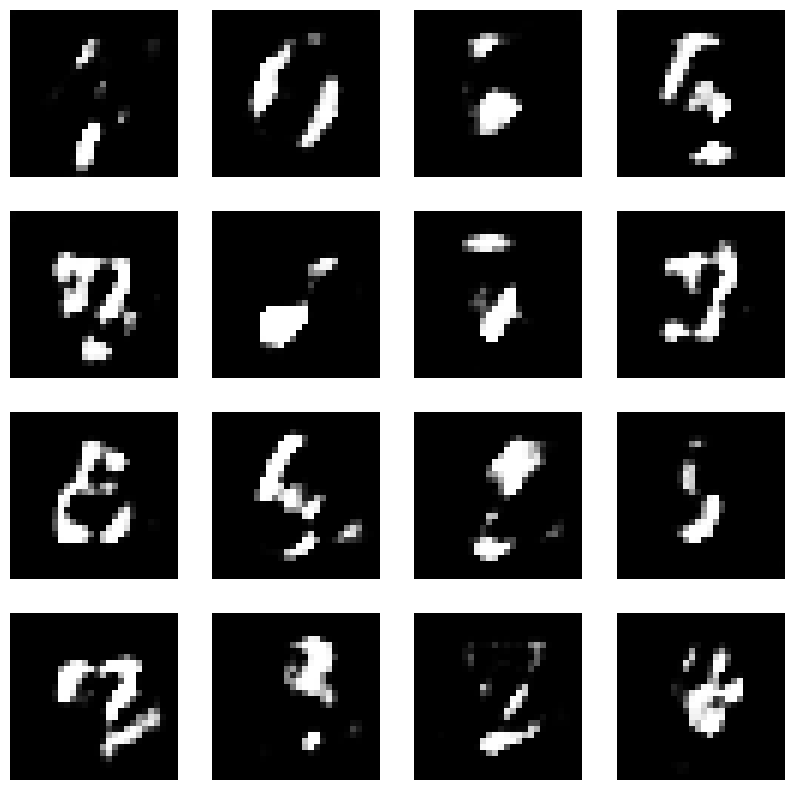

Epoch:  39


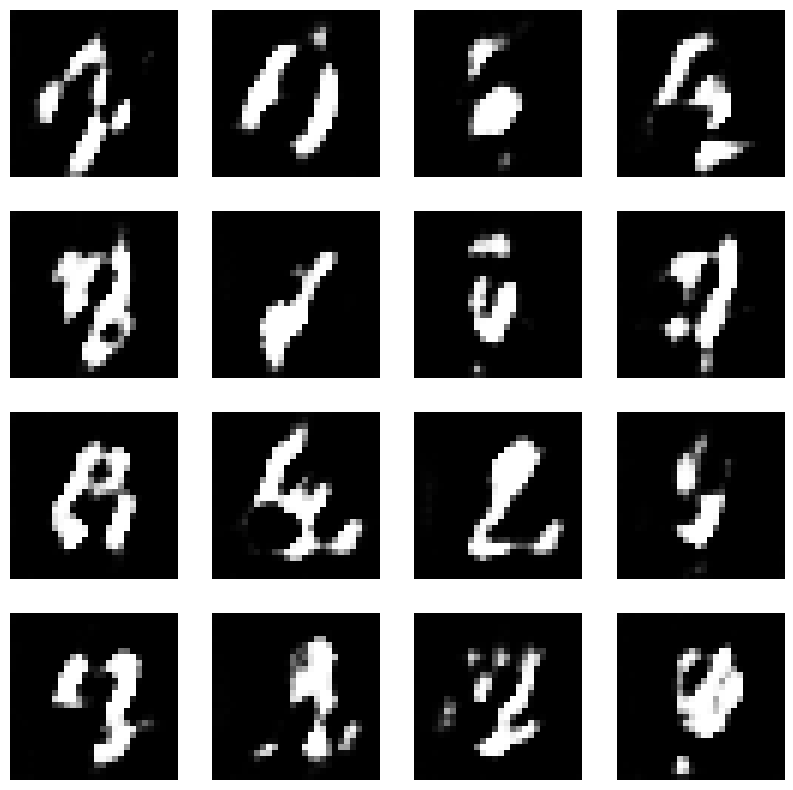

Epoch:  40


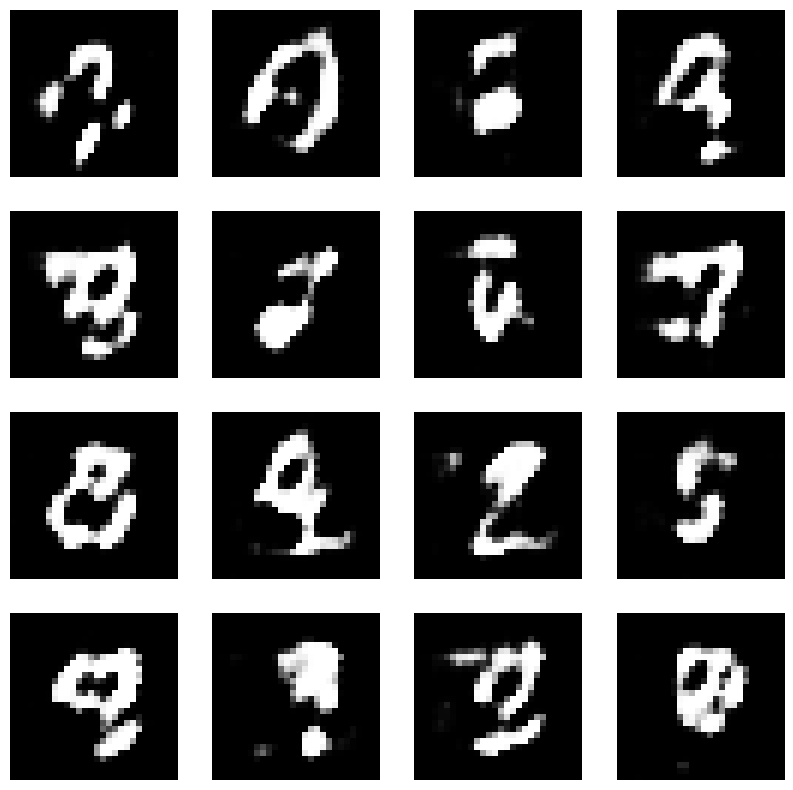

Epoch:  41


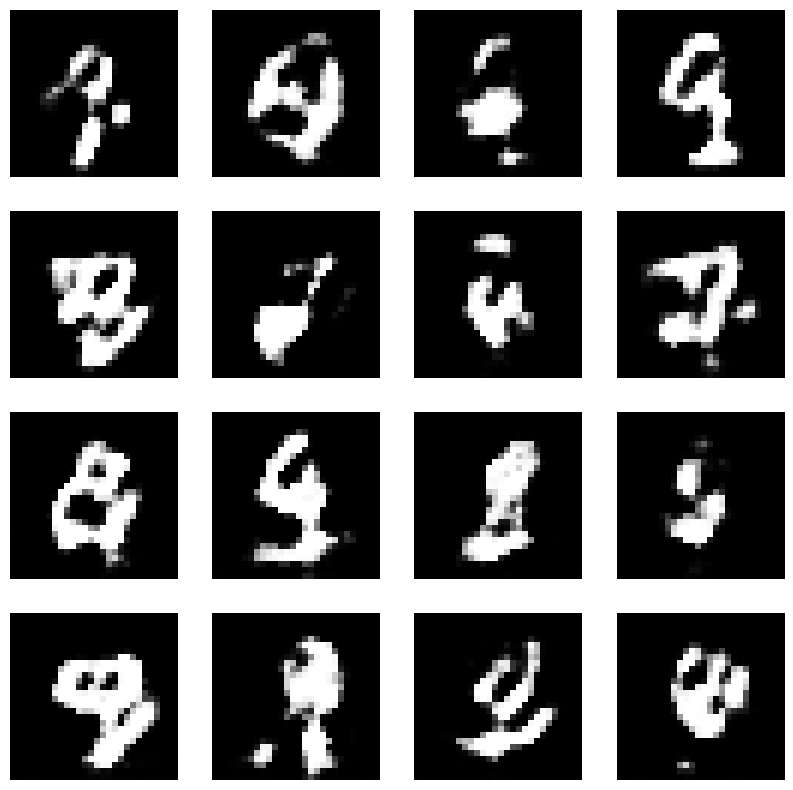

Epoch:  42


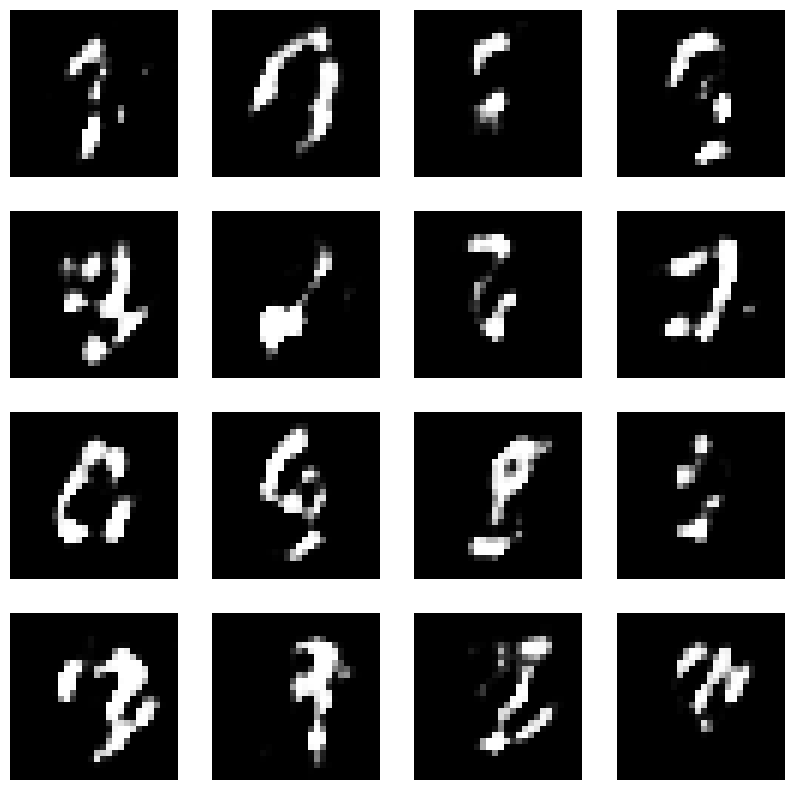

Epoch:  43


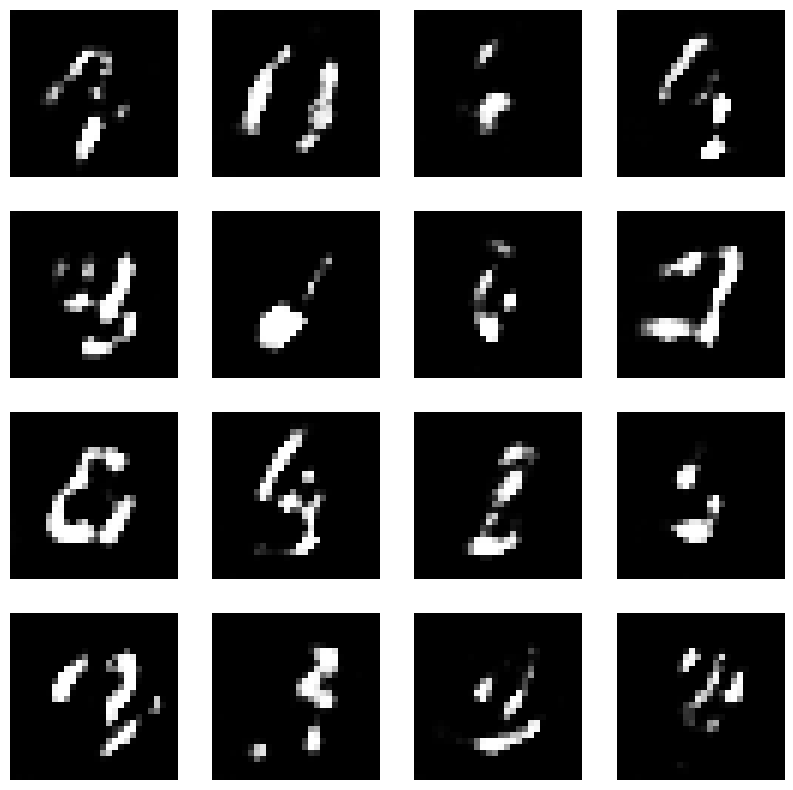

Epoch:  44


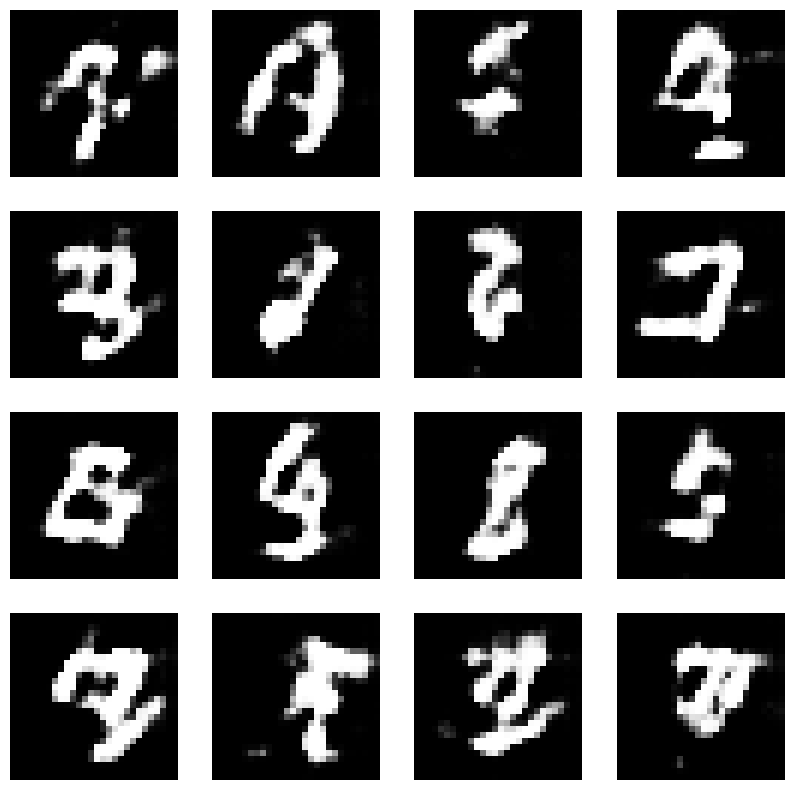

Epoch:  45


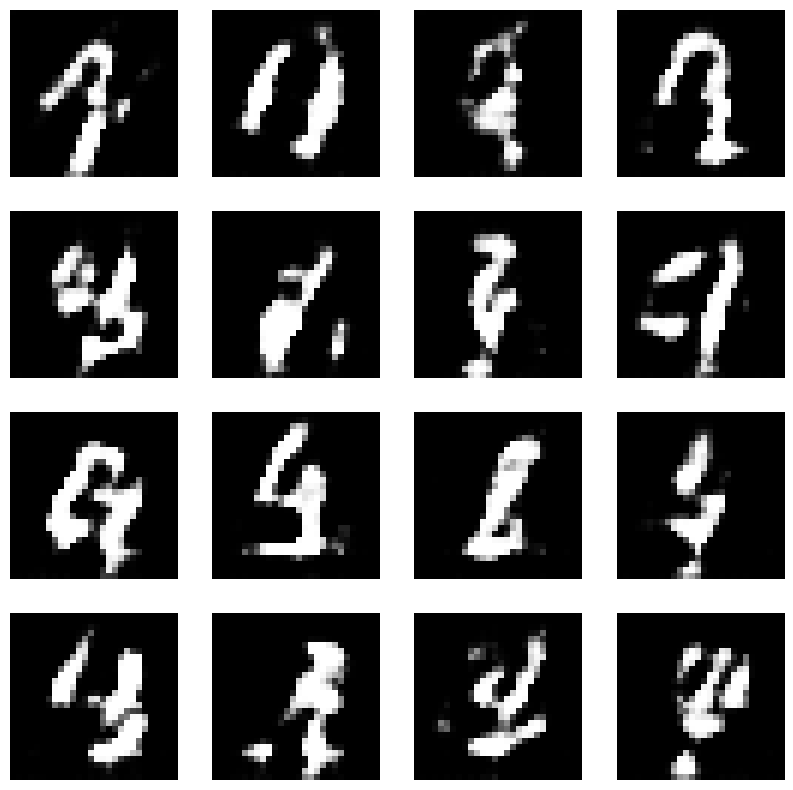

Epoch:  46


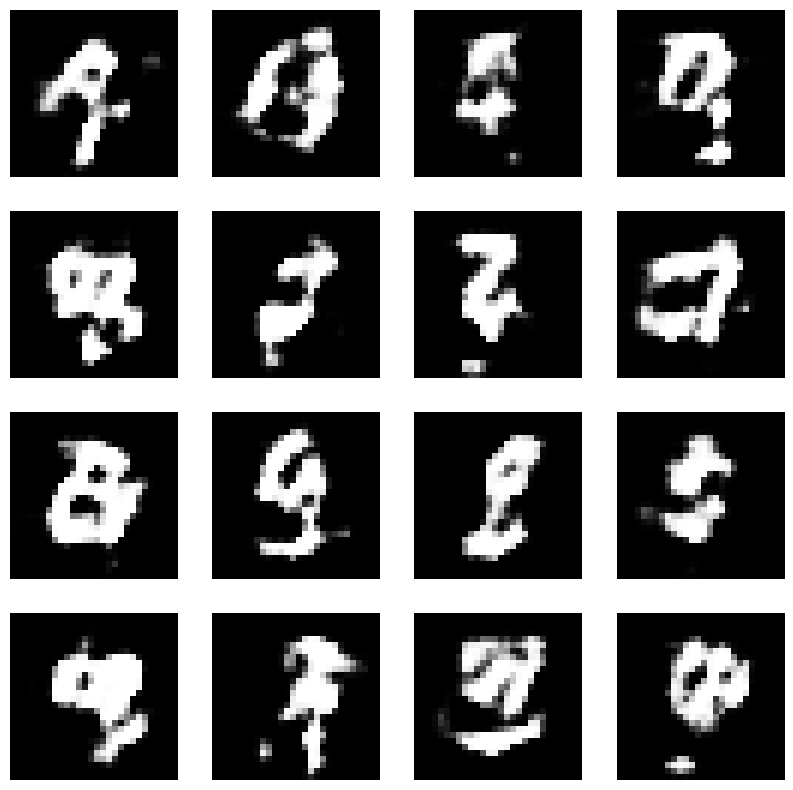

Epoch:  47


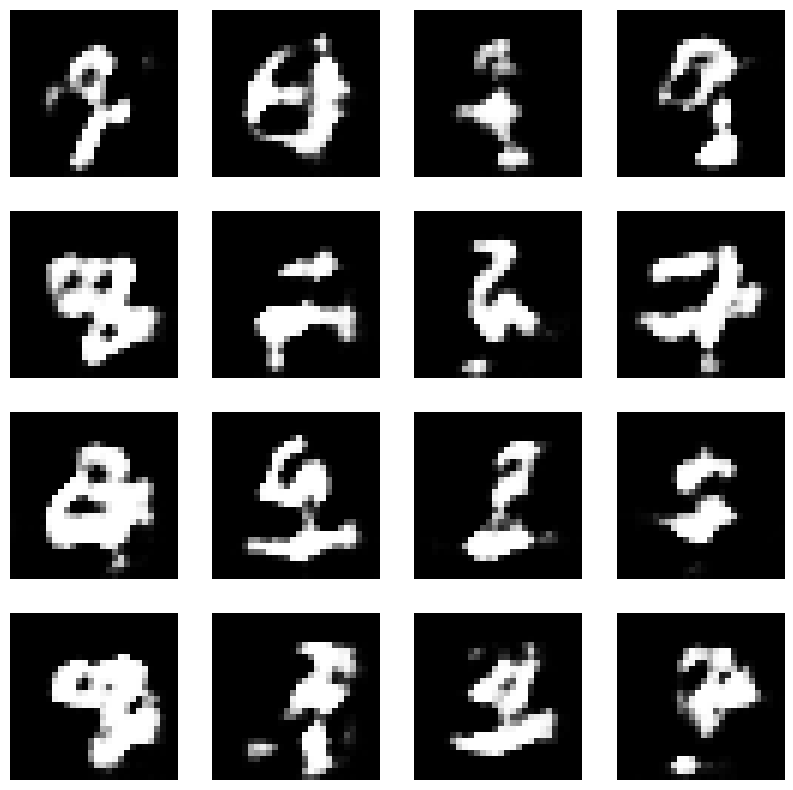

Epoch:  48


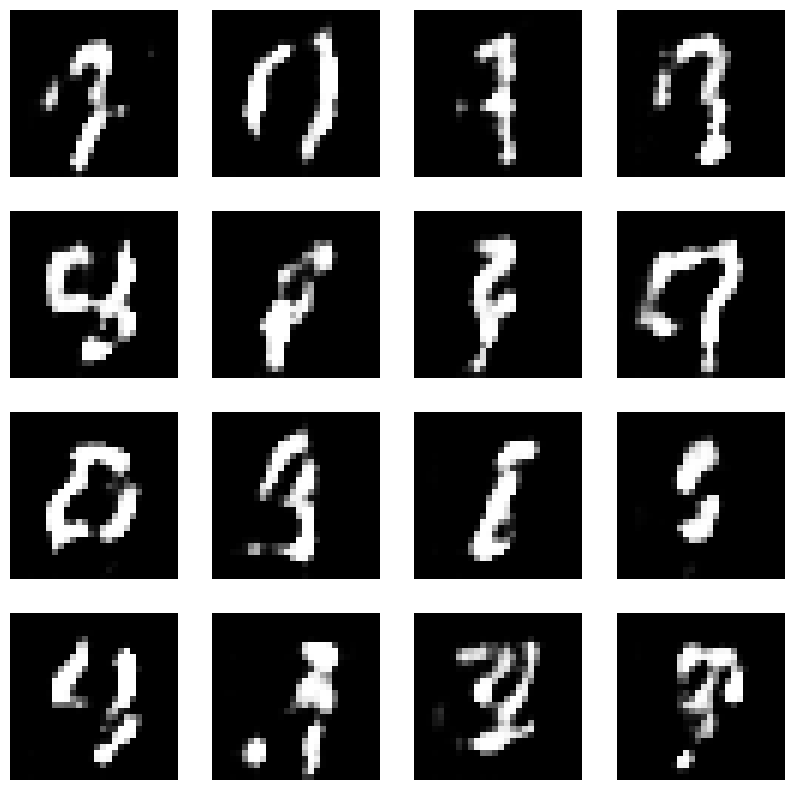

Epoch:  49


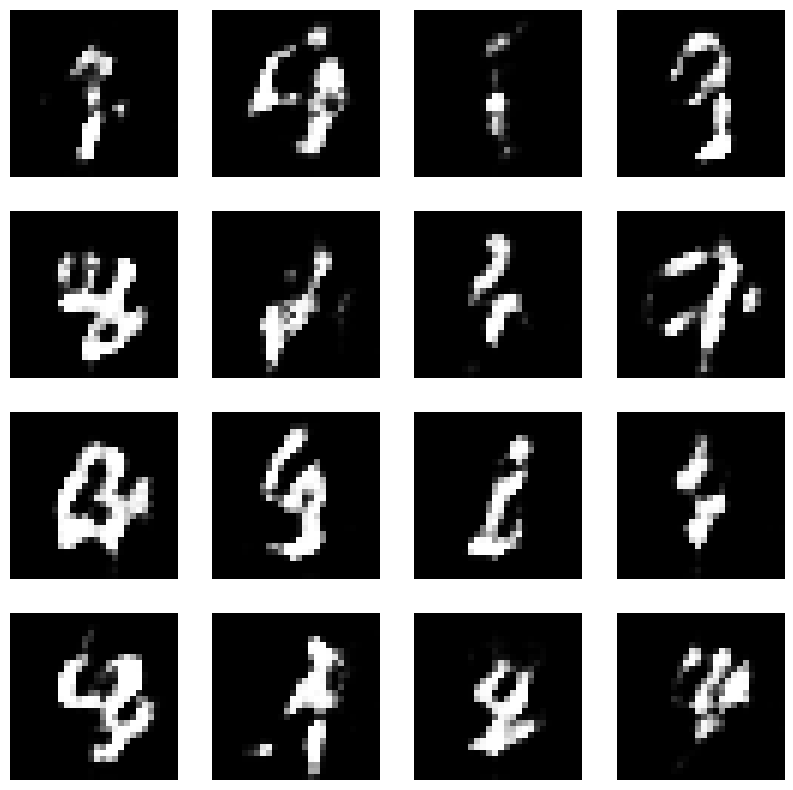

Epoch:  50


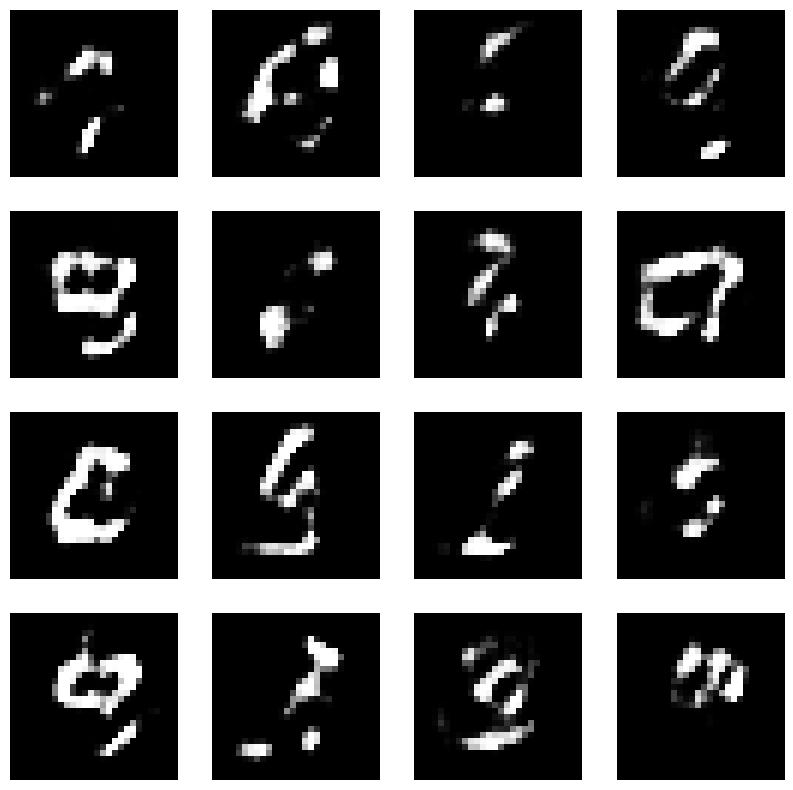

Epoch:  51


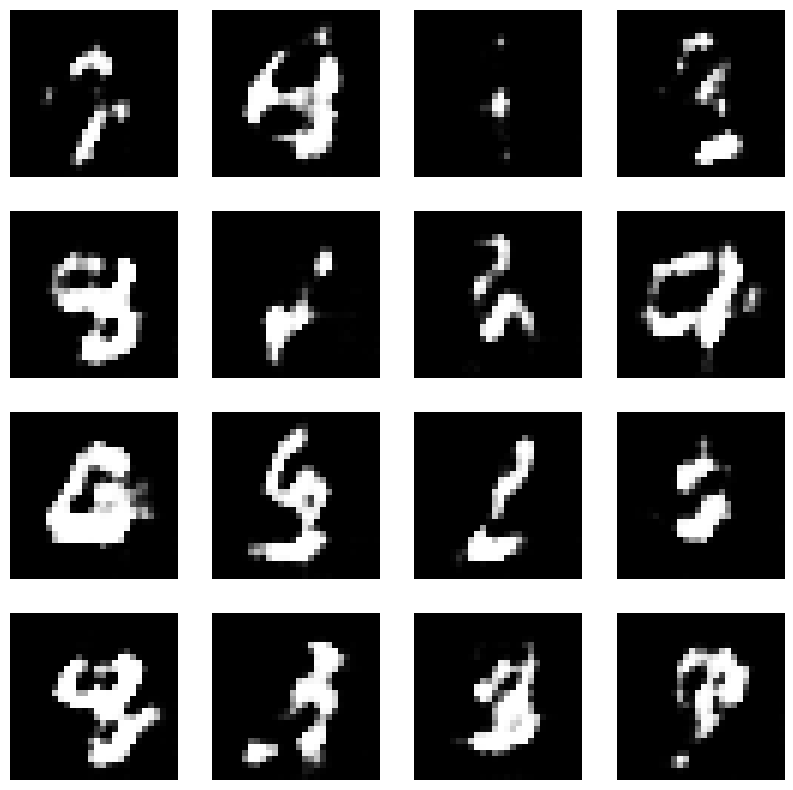

Epoch:  52


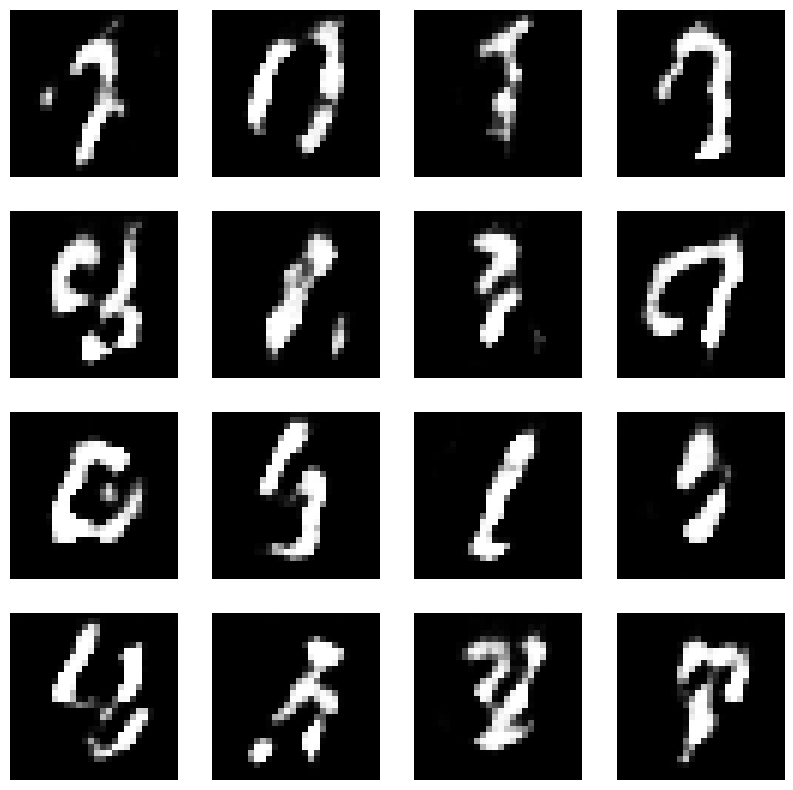

Epoch:  53


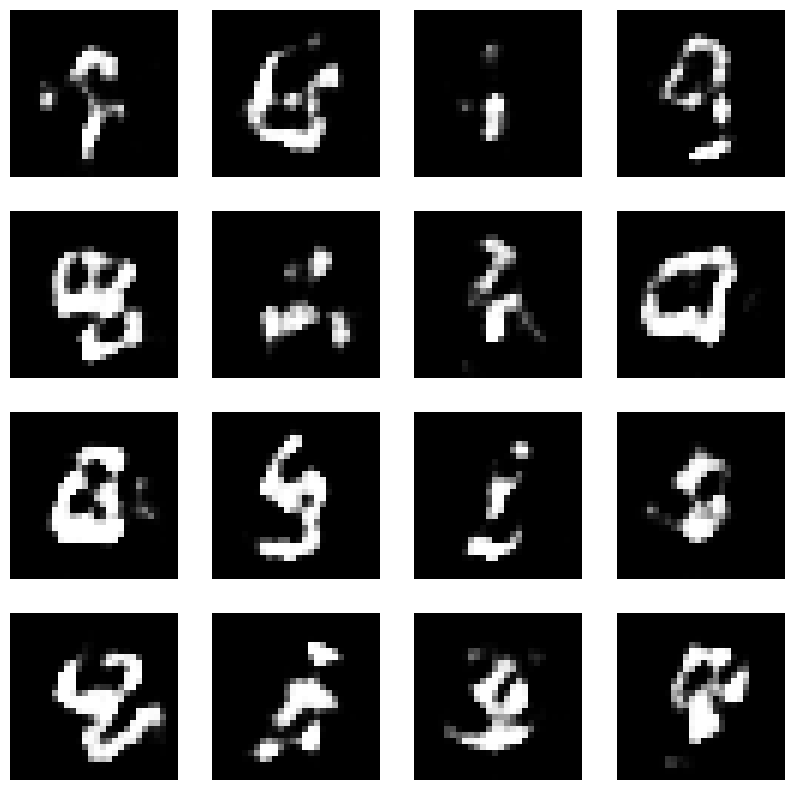

Epoch:  54


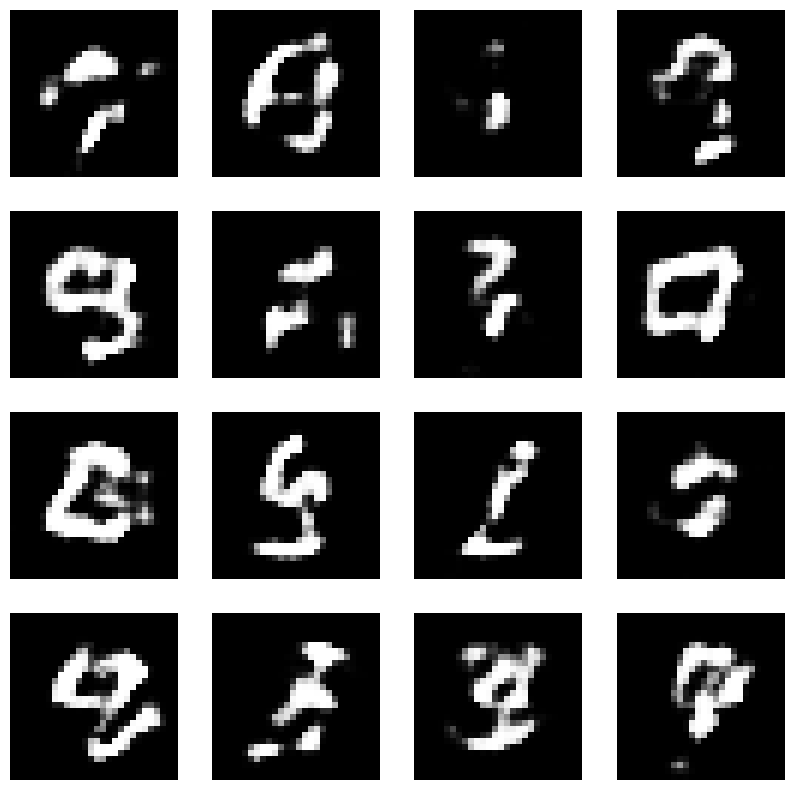

Epoch:  55


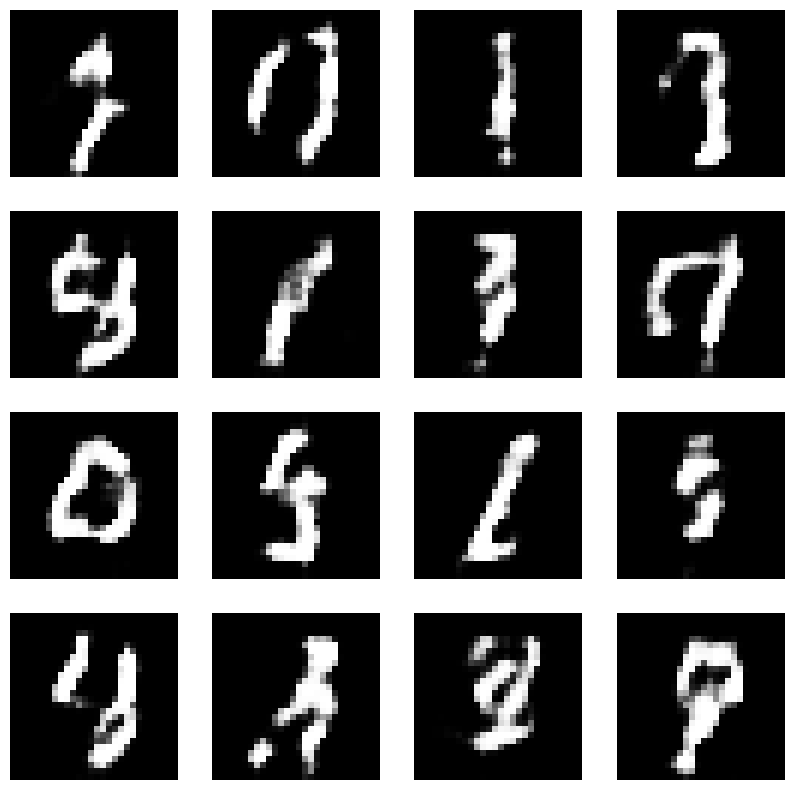

Epoch:  56


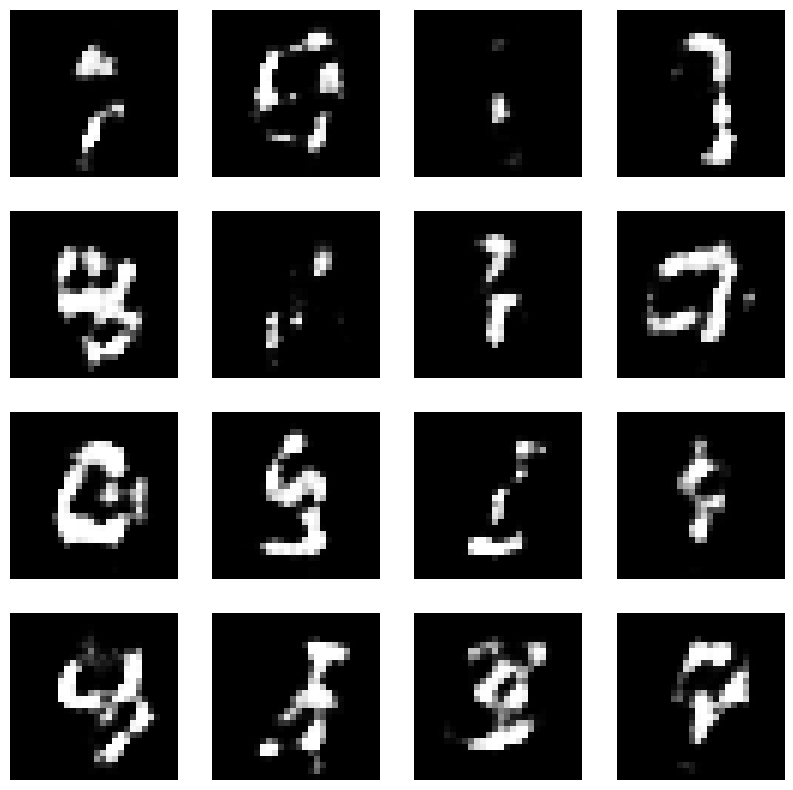

Epoch:  57


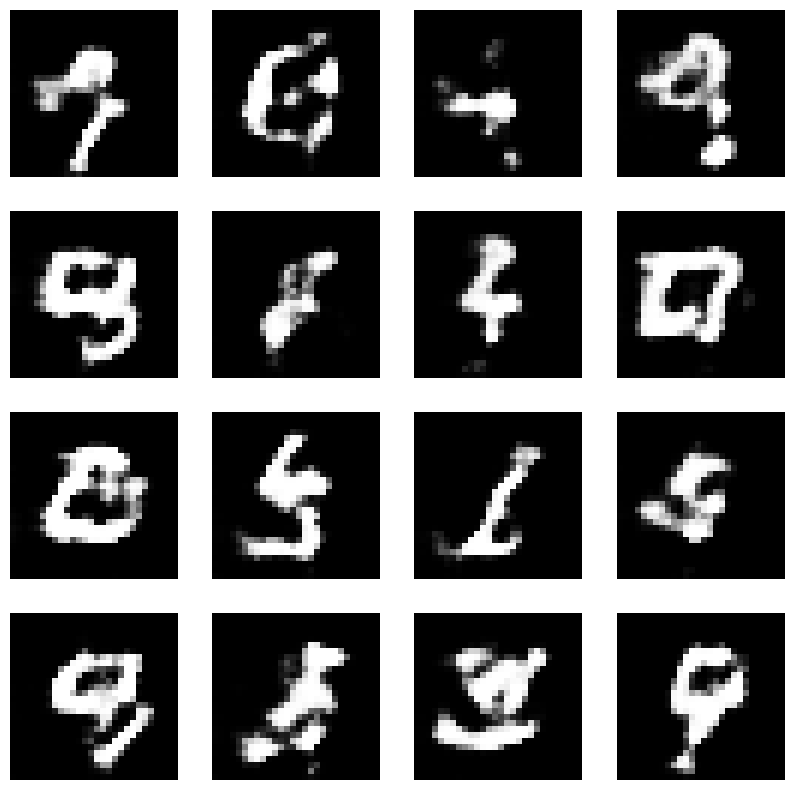

Epoch:  58


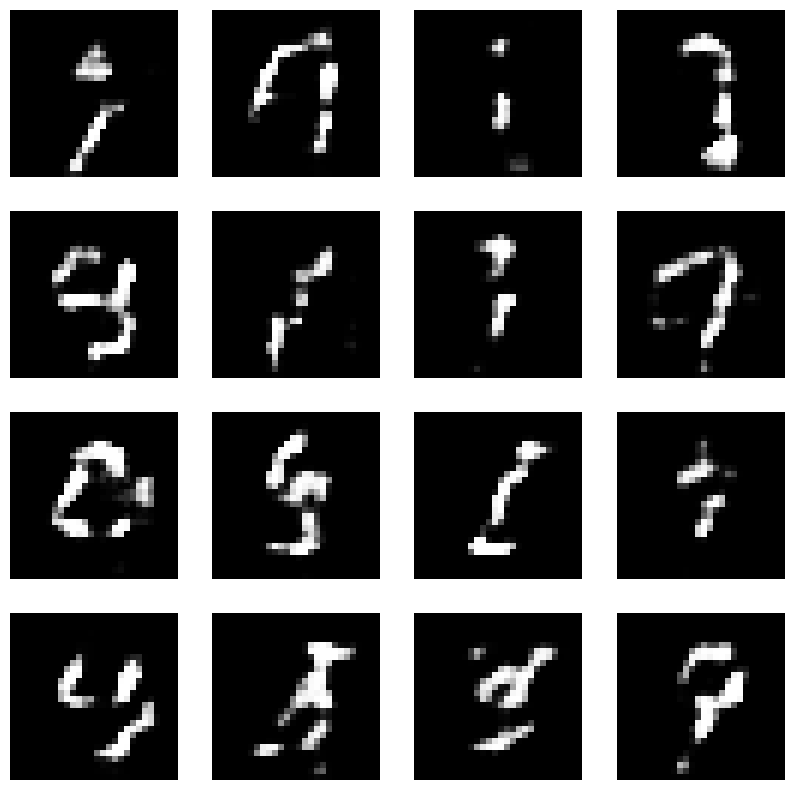

Epoch:  59


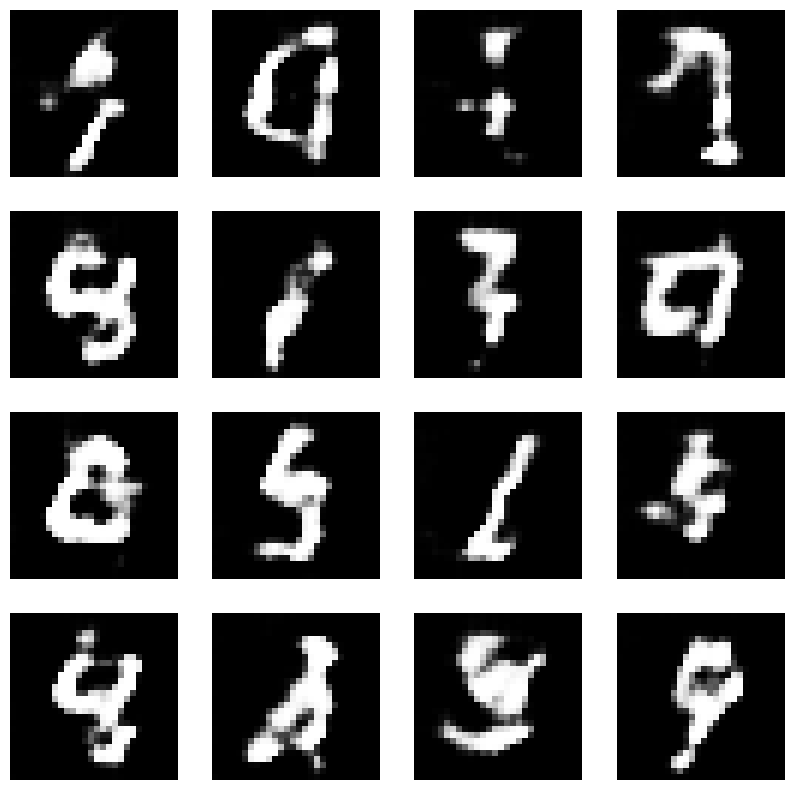

Epoch:  60


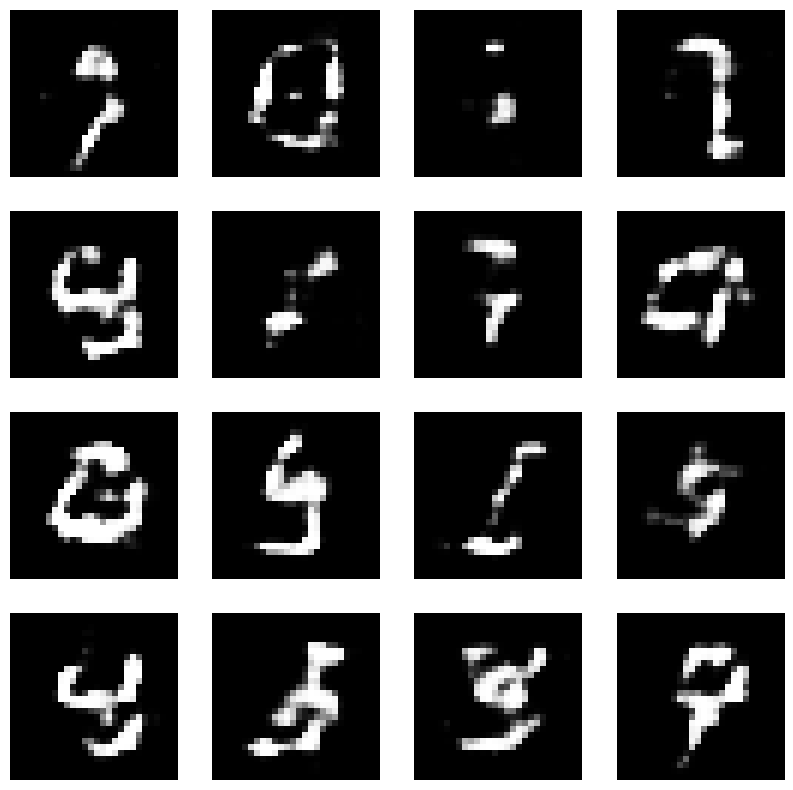

Epoch:  61


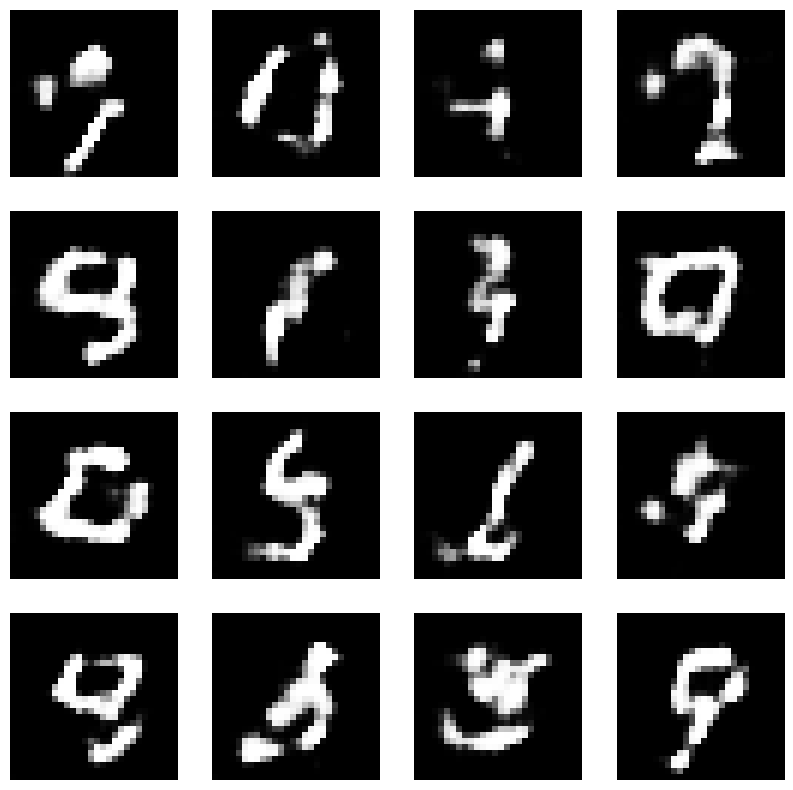

Epoch:  62


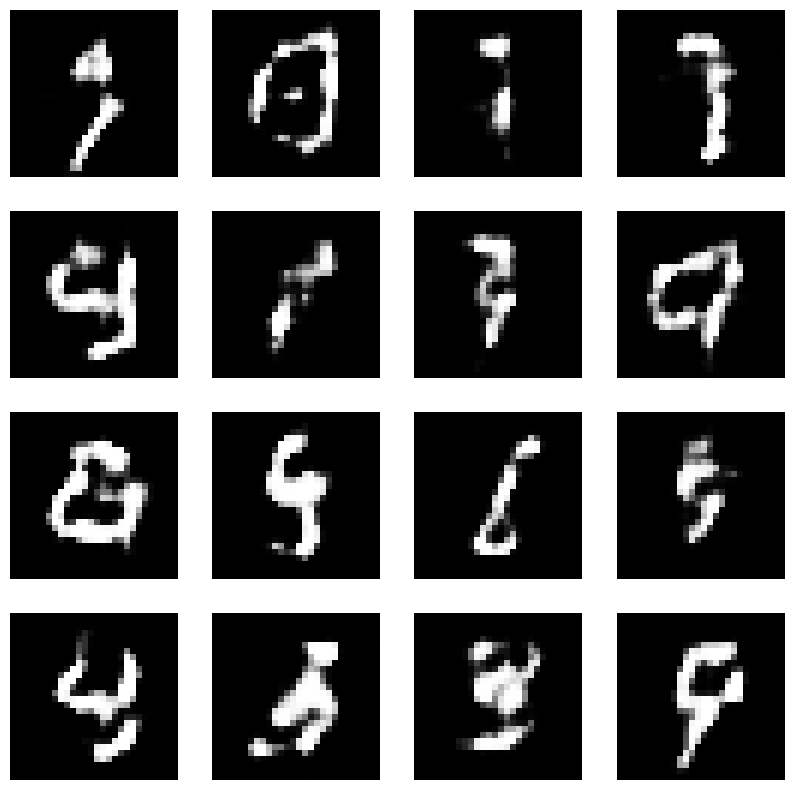

Epoch:  63


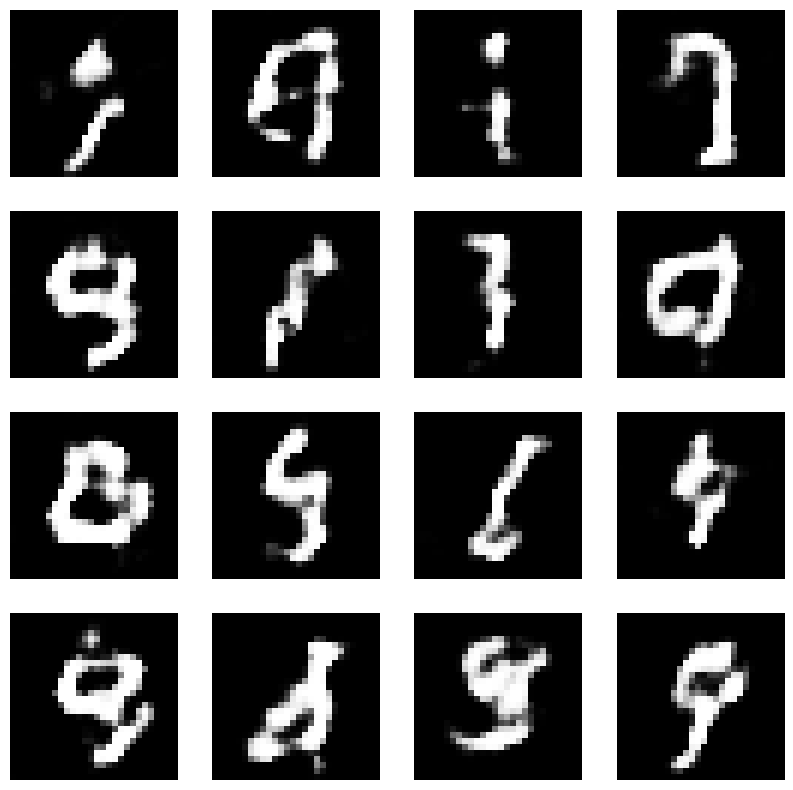

Epoch:  64


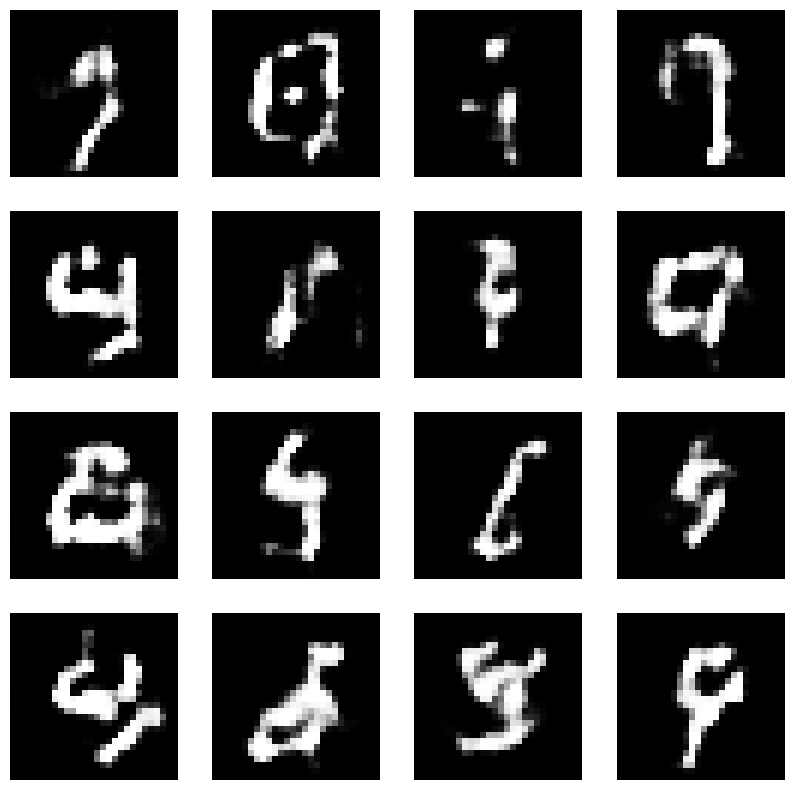

Epoch:  65


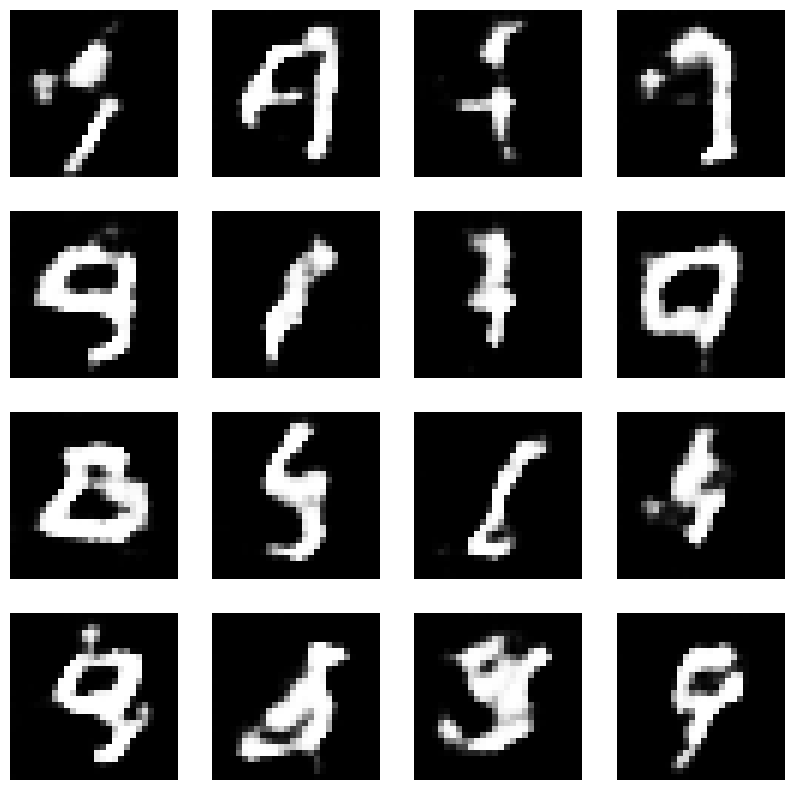

Epoch:  66


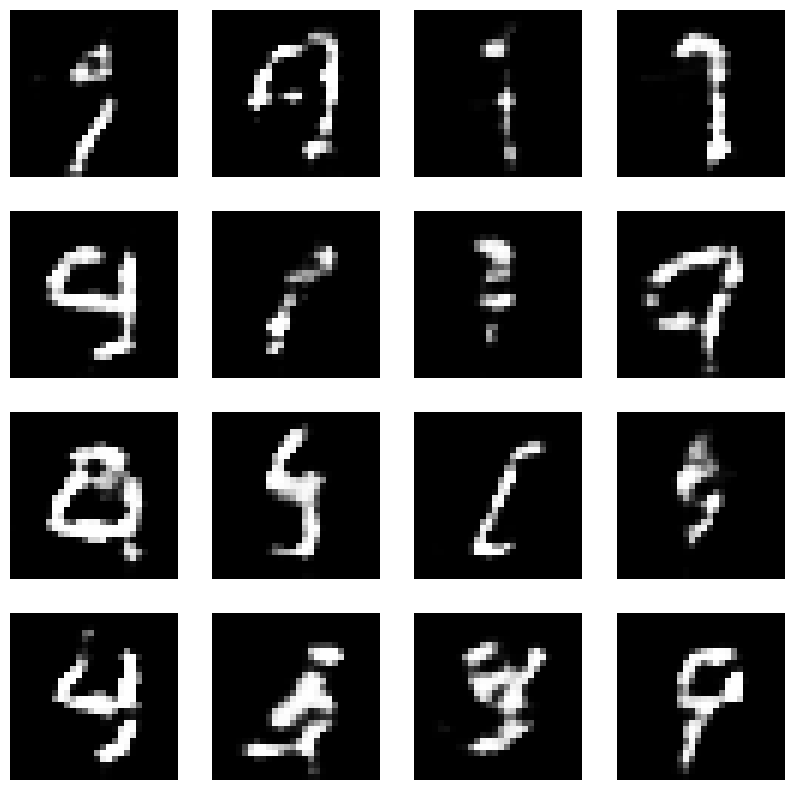

Epoch:  67


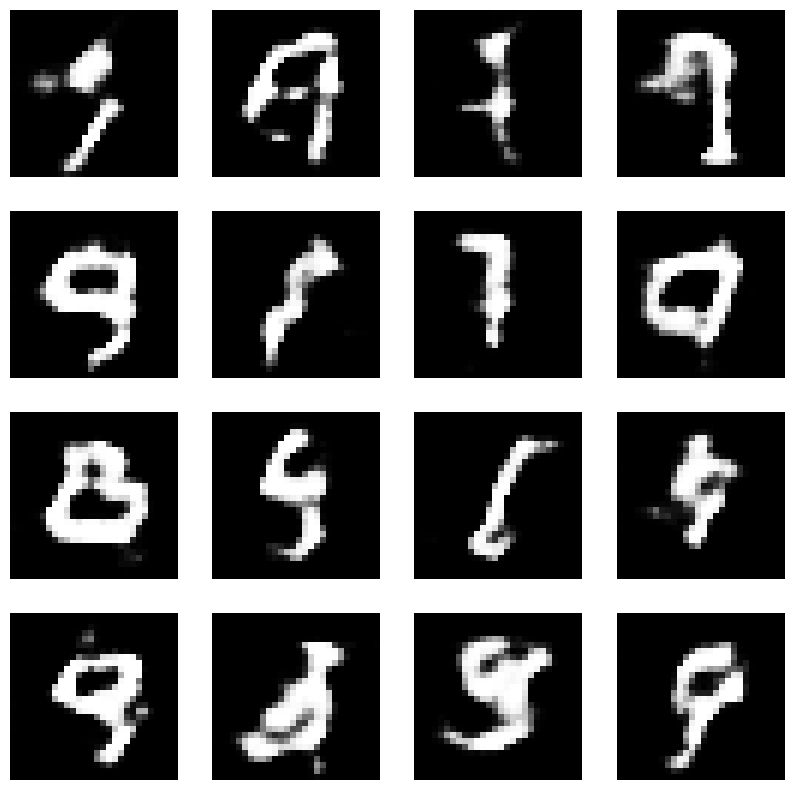

Epoch:  68


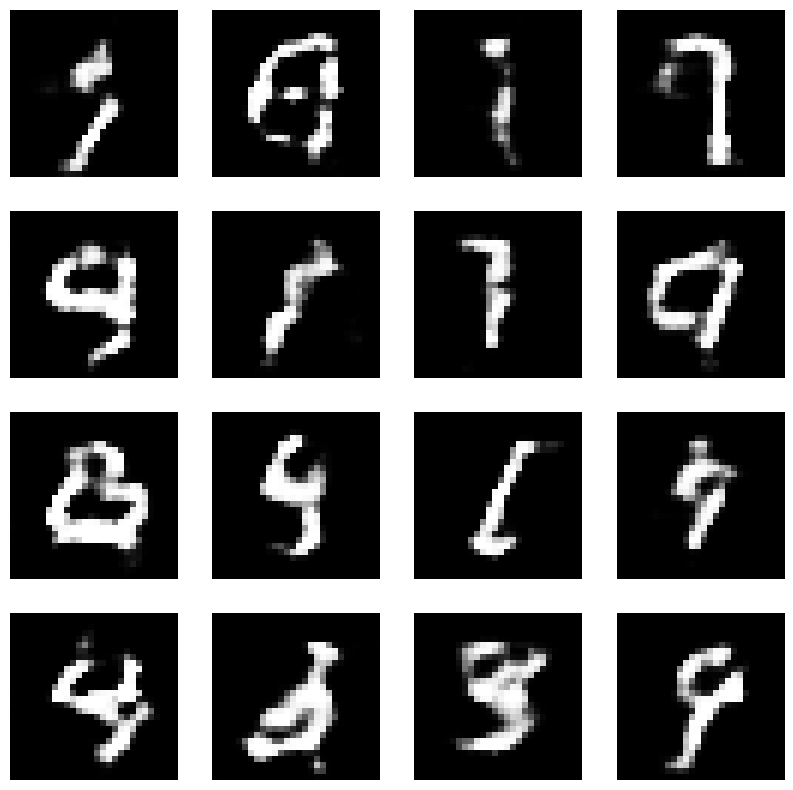

Epoch:  69


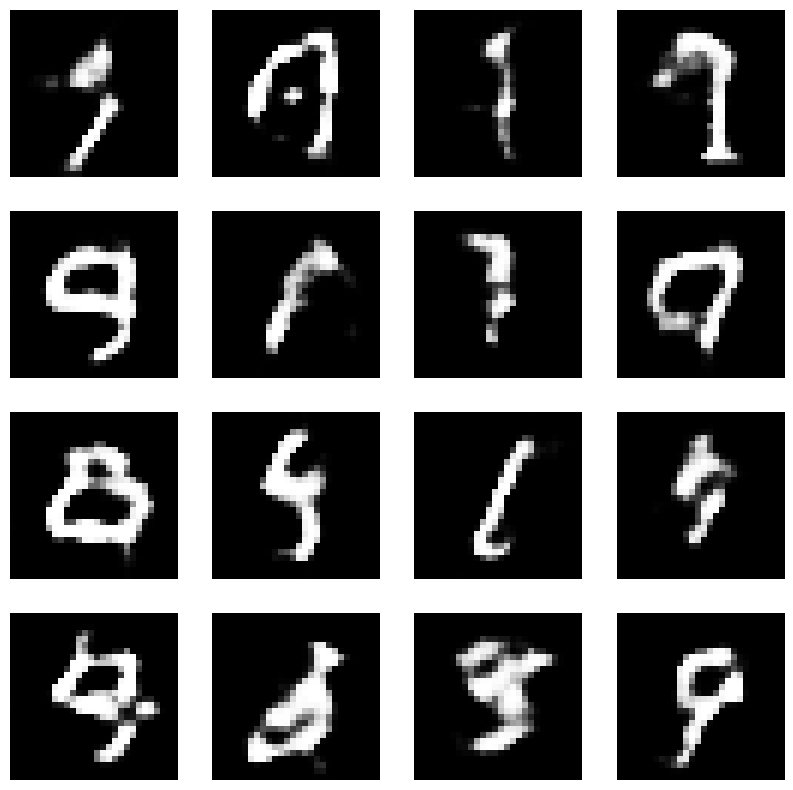

Epoch:  70


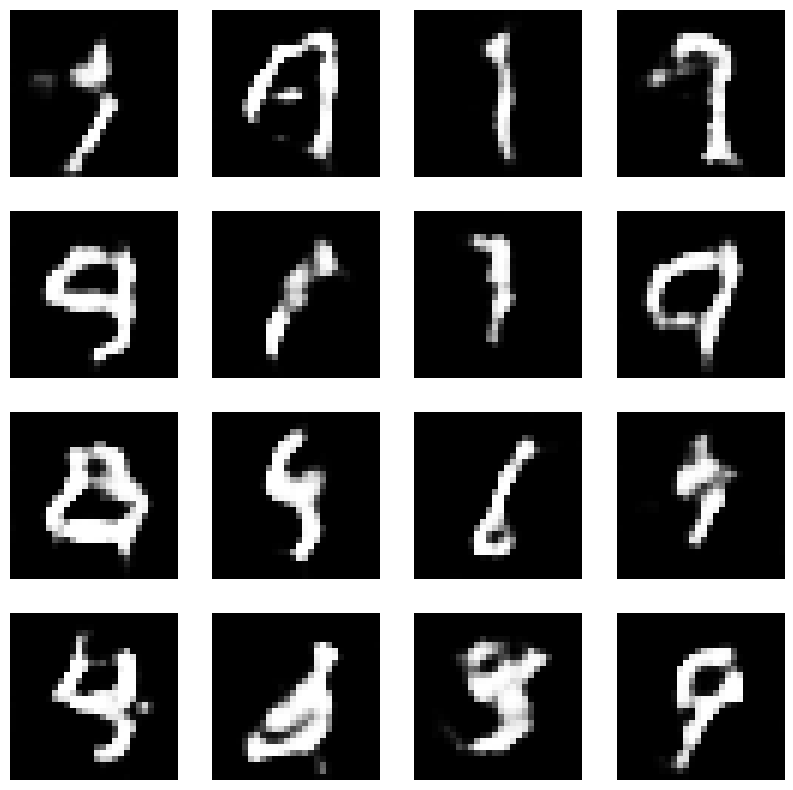

Epoch:  71


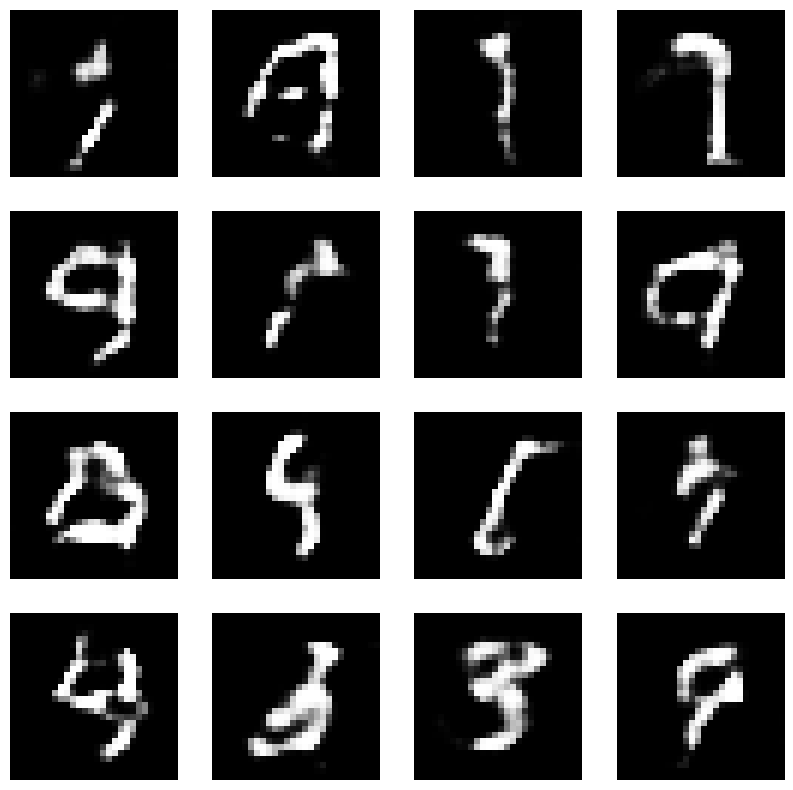

Epoch:  72


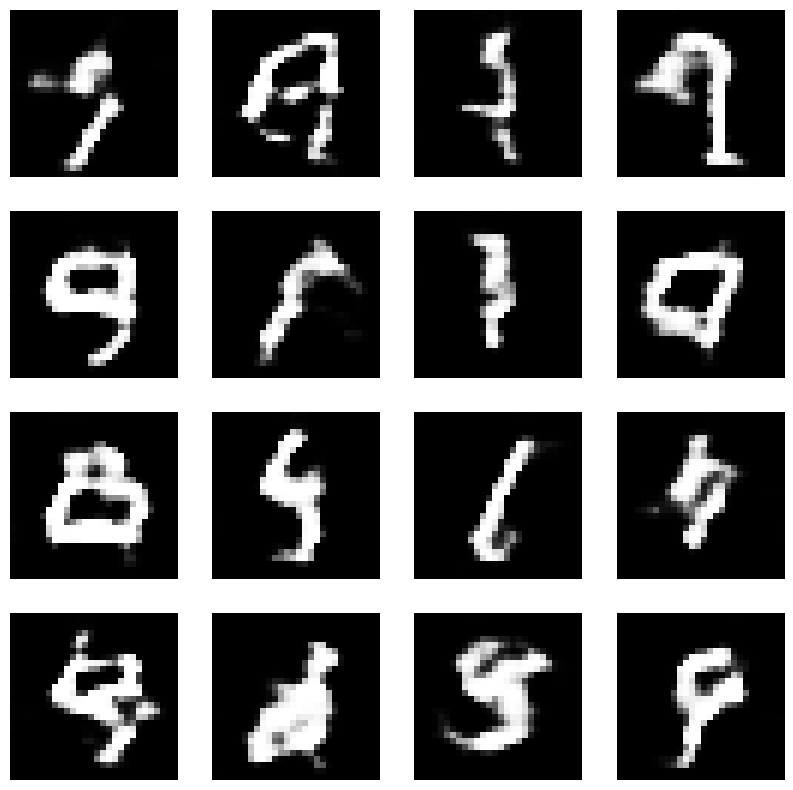

Epoch:  73


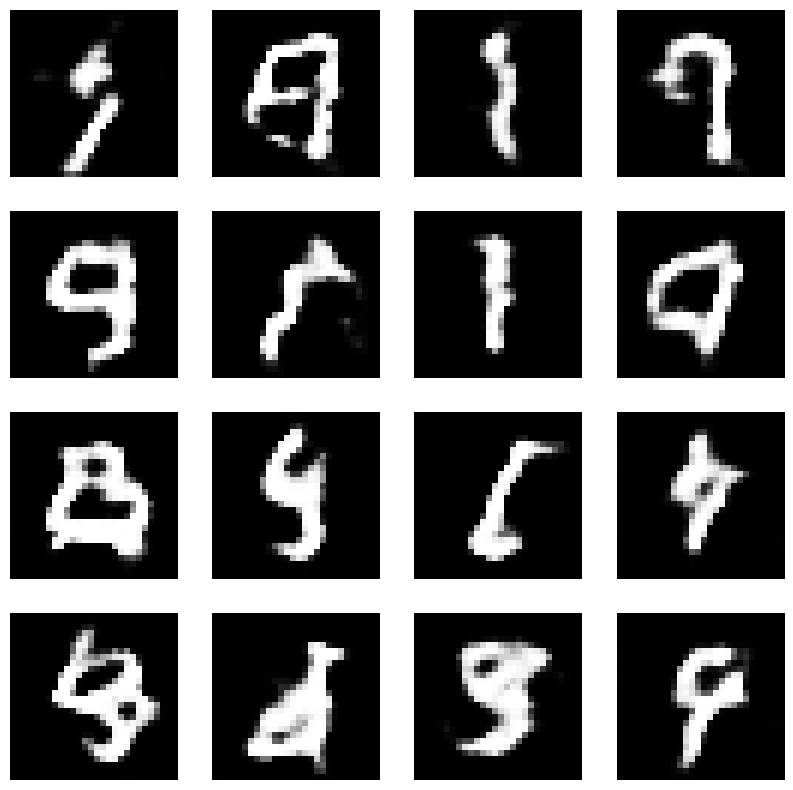

Epoch:  74


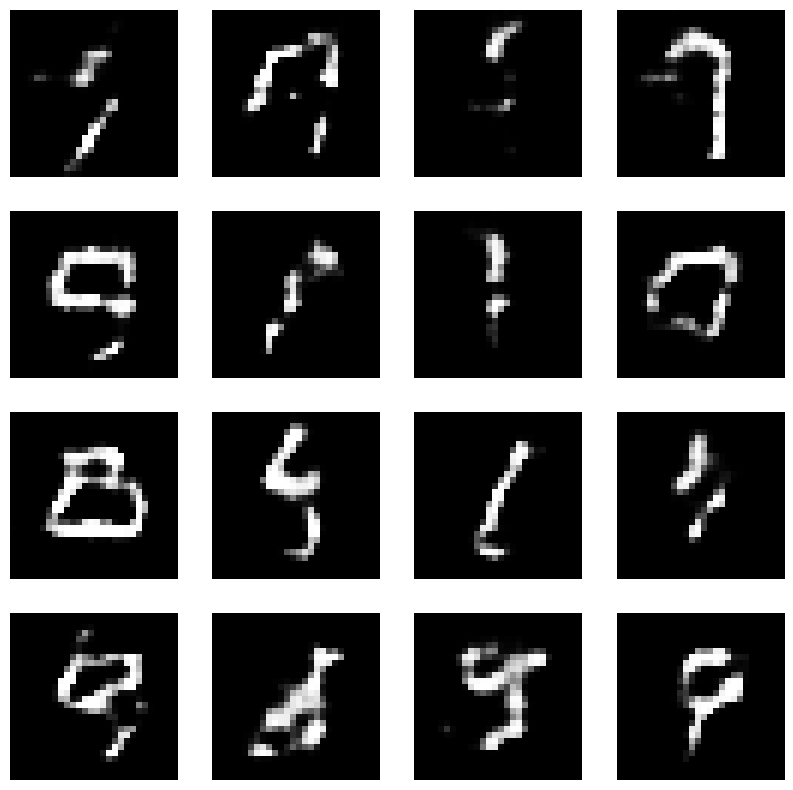

Epoch:  75


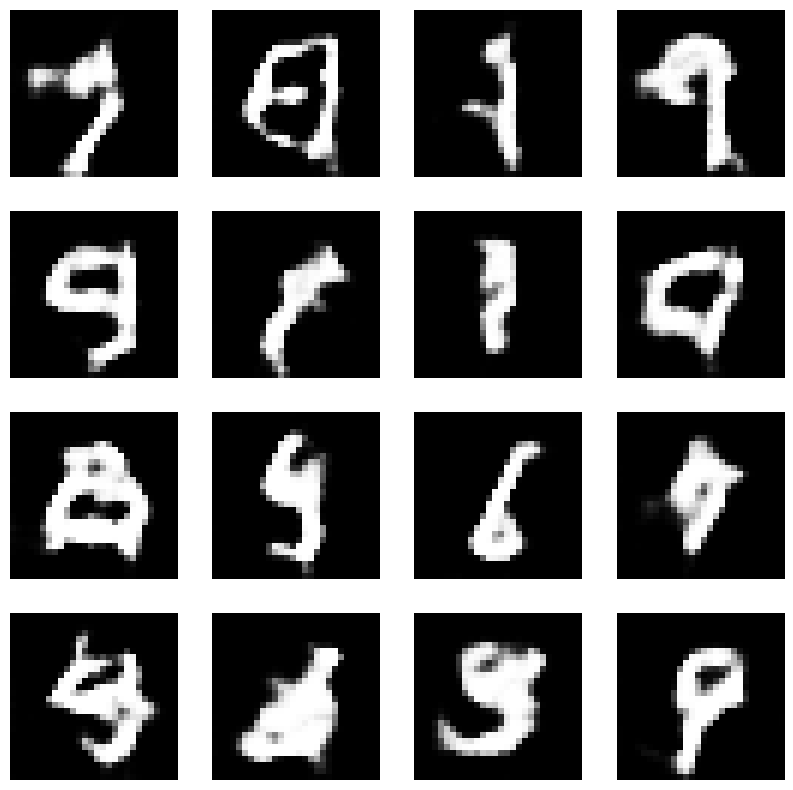

Epoch:  76


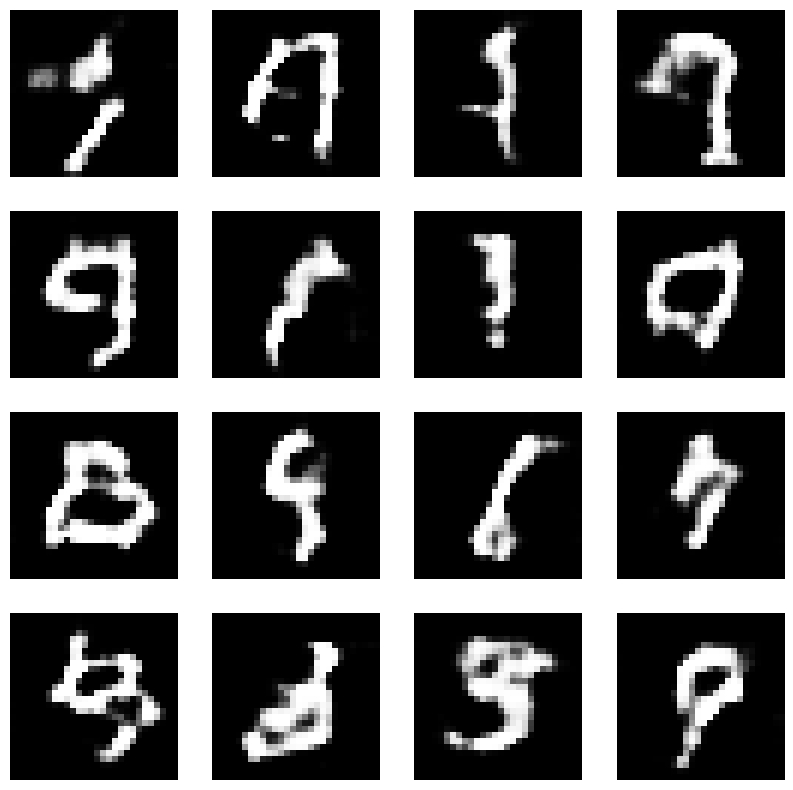

Epoch:  77


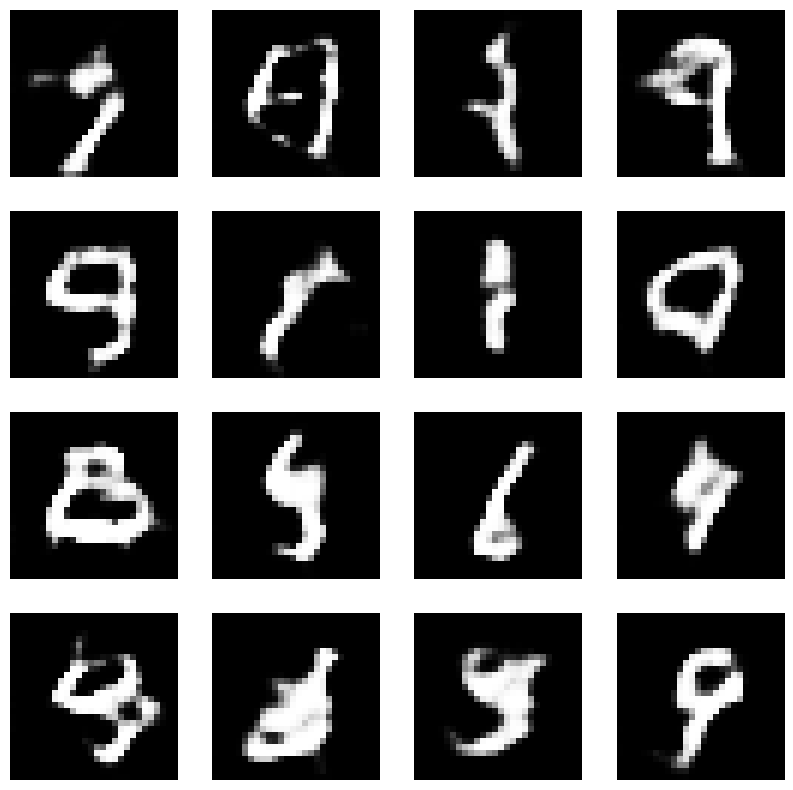

Epoch:  78


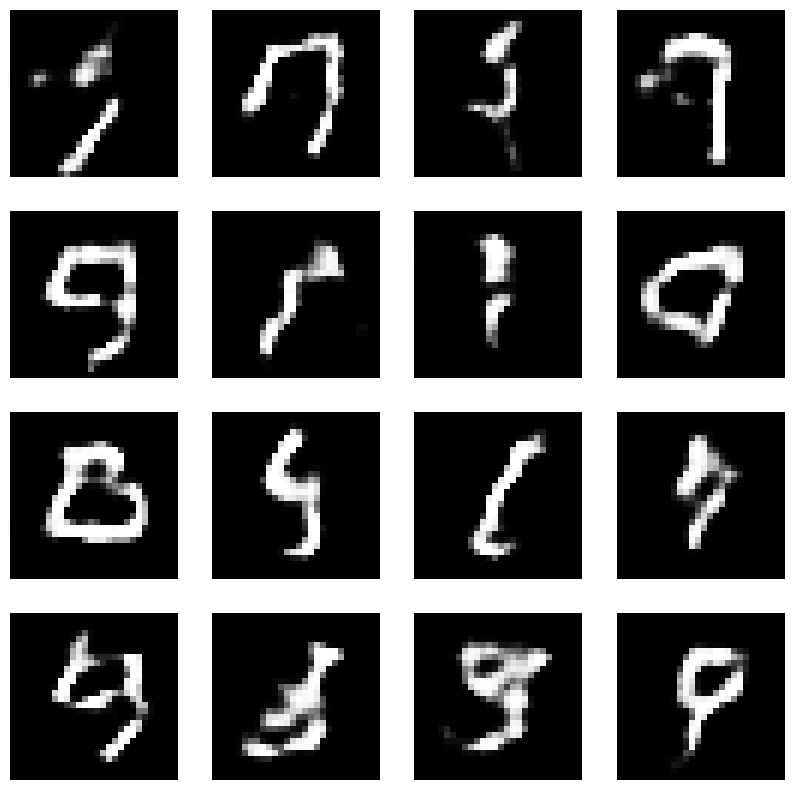

Epoch:  79


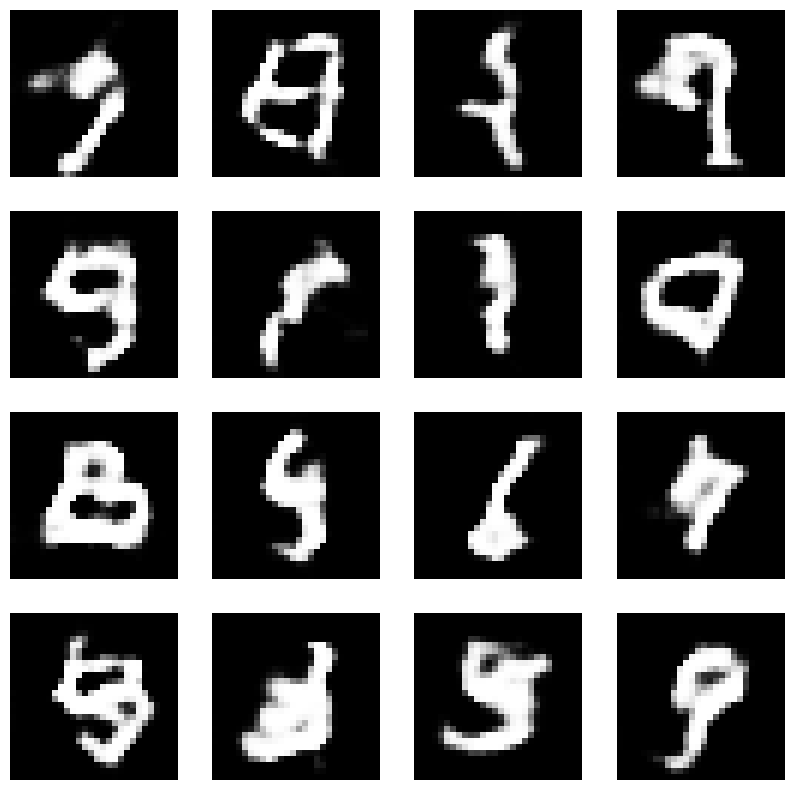

Epoch:  80


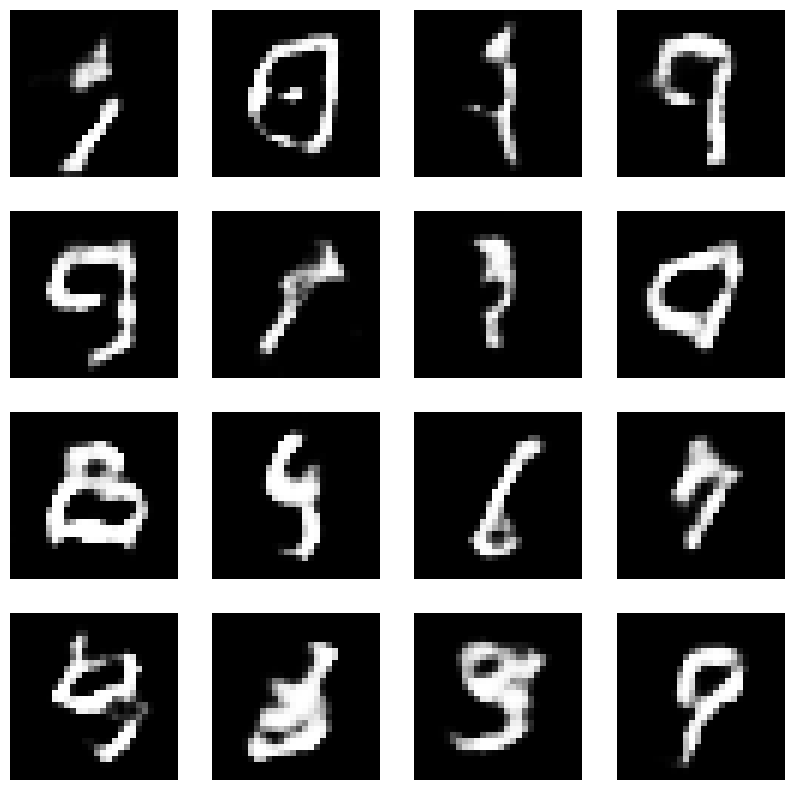

Epoch:  81


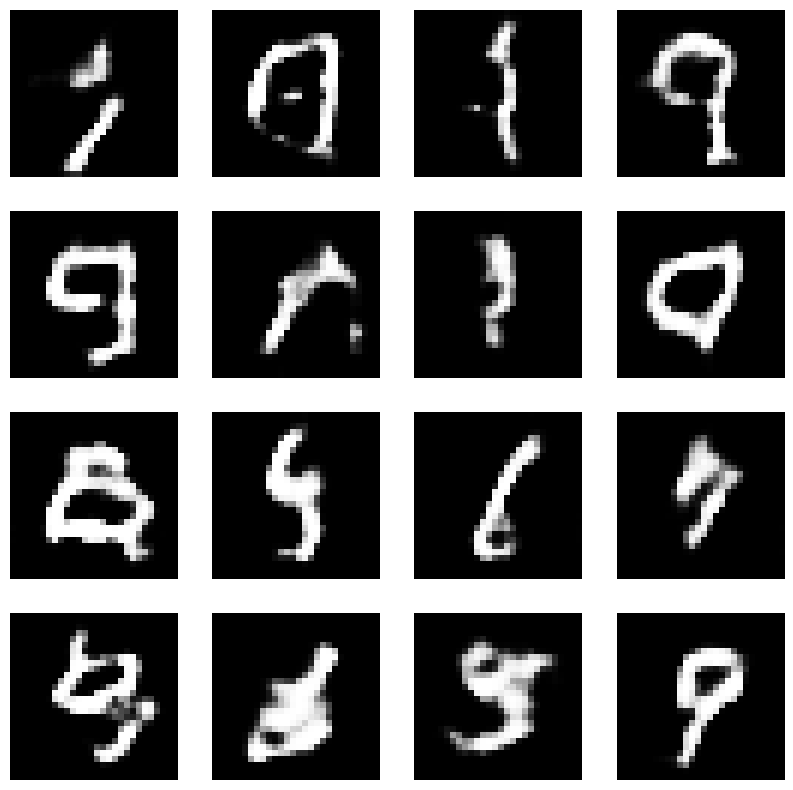

Epoch:  82


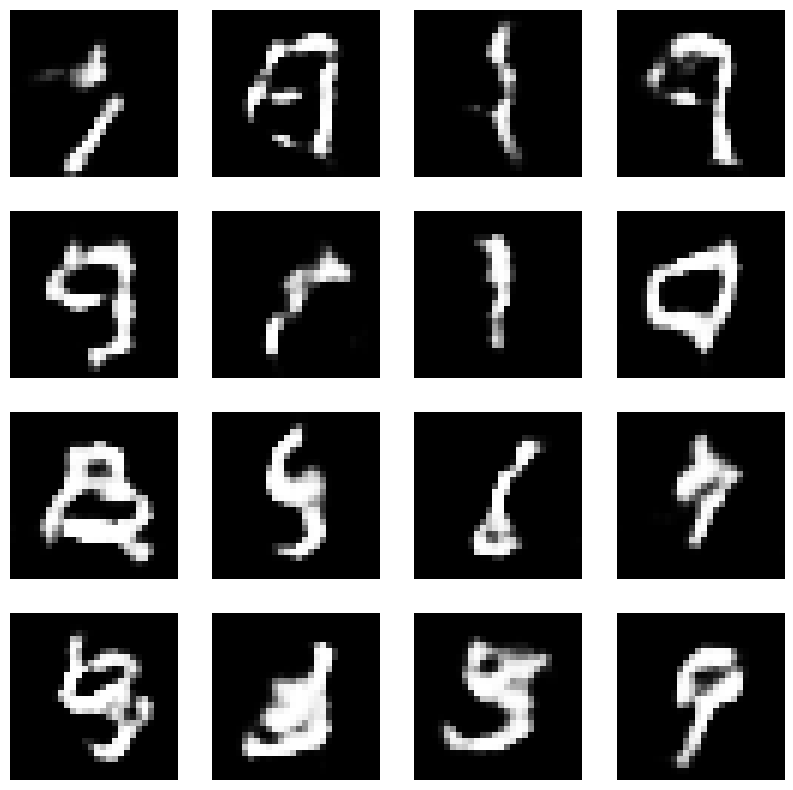

Epoch:  83


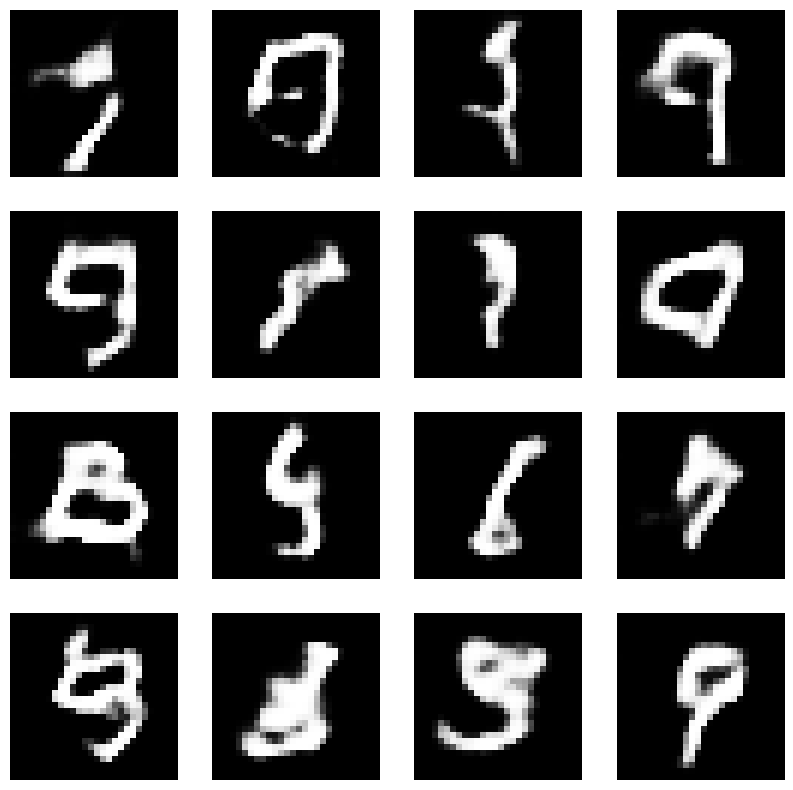

Epoch:  84


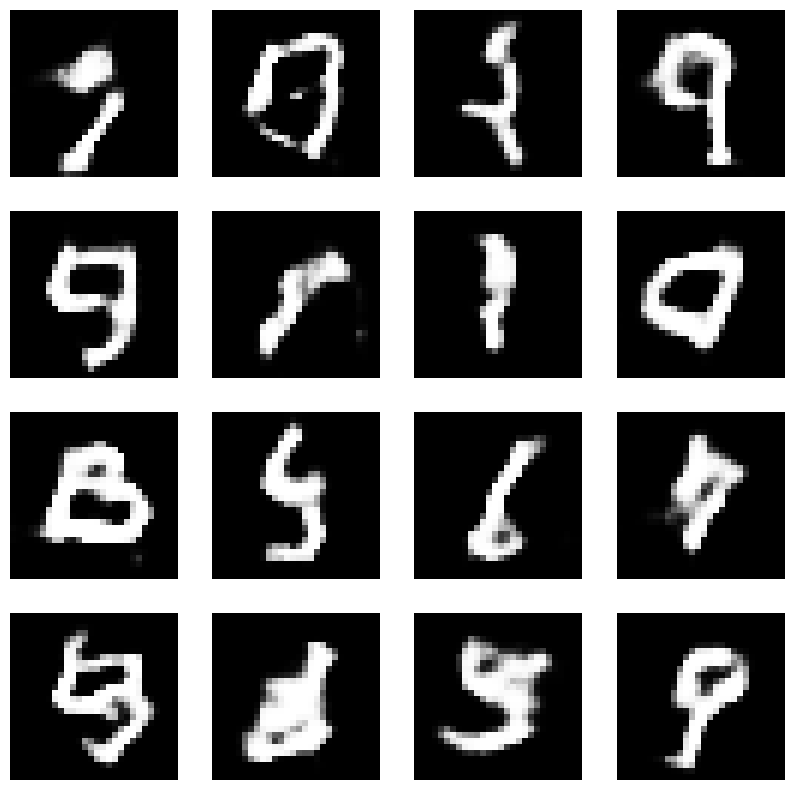

Epoch:  85


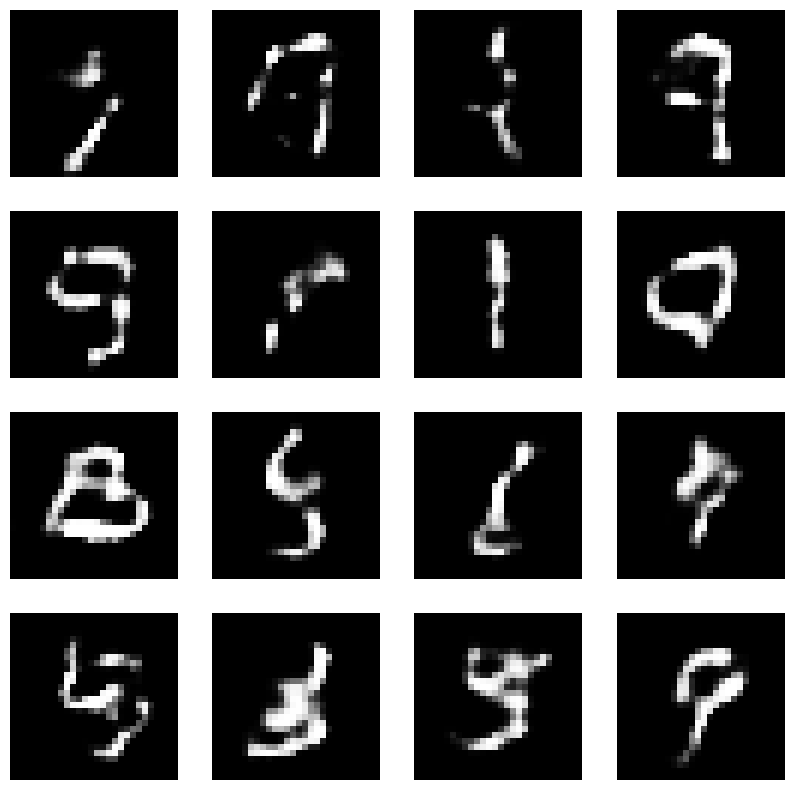

Epoch:  86


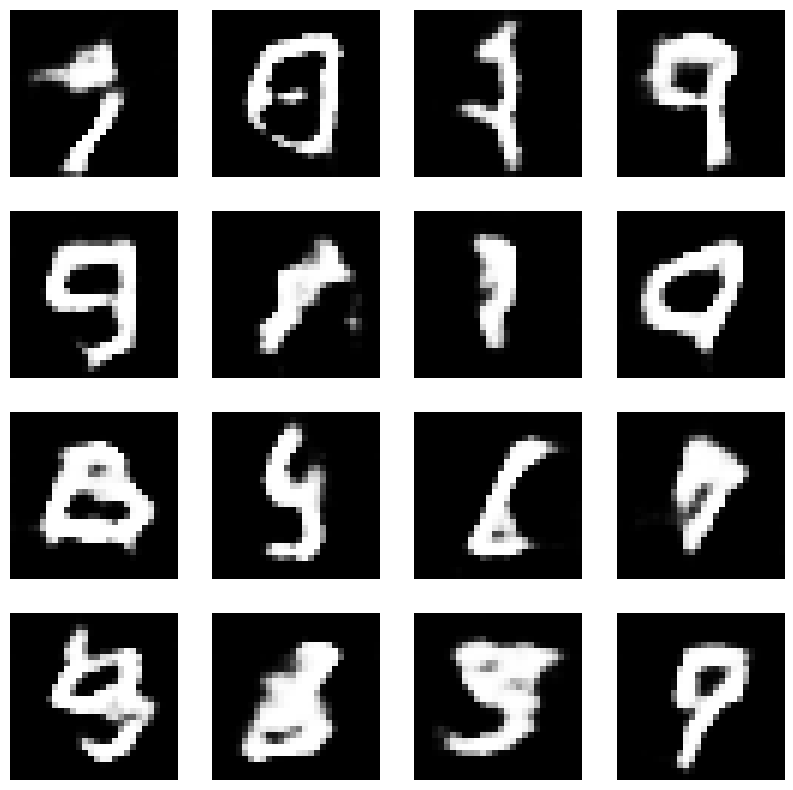

Epoch:  87


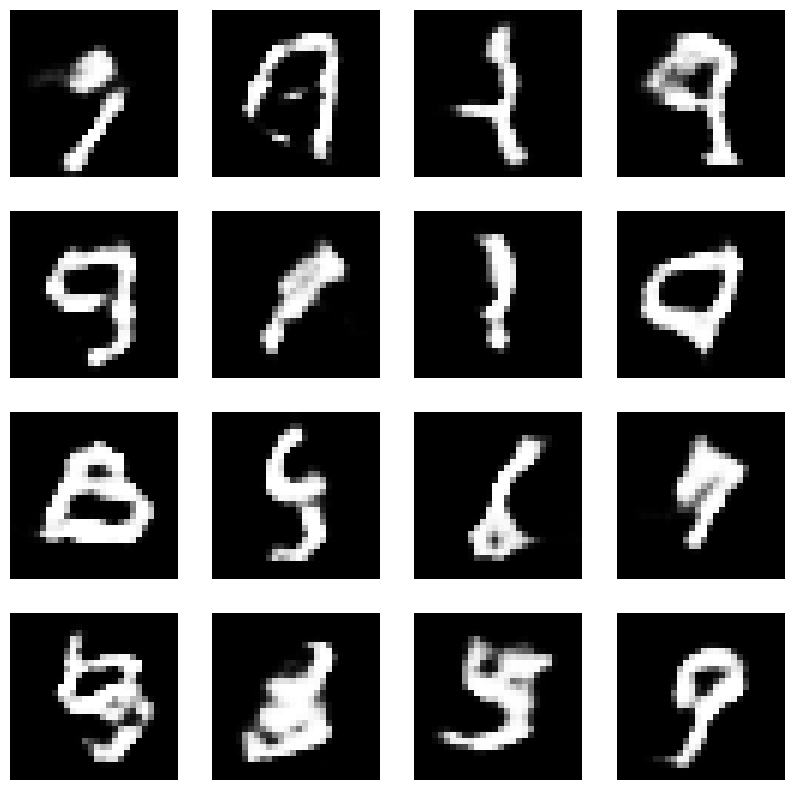

Epoch:  88


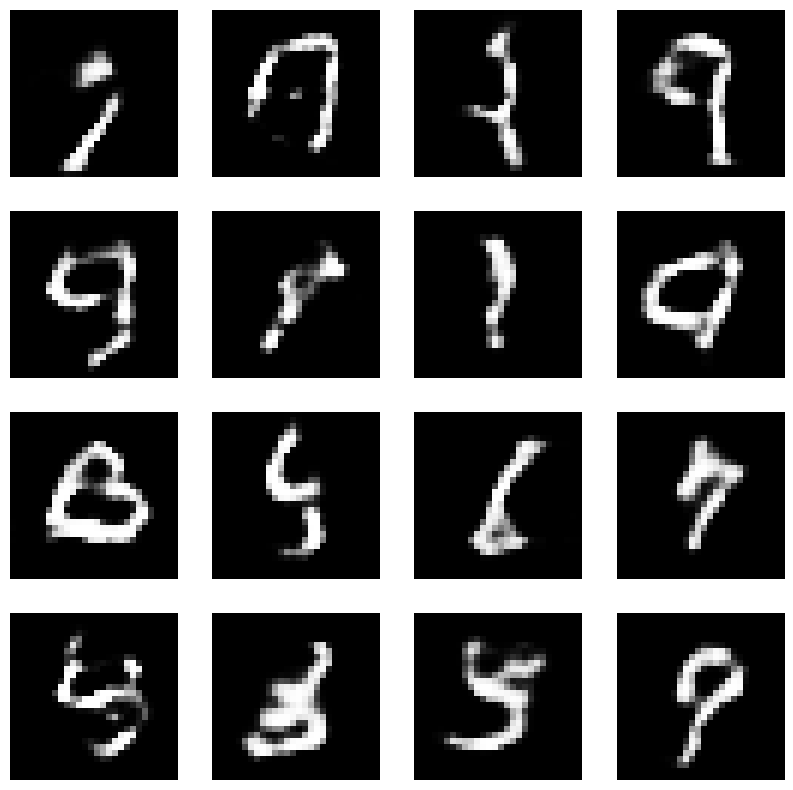

Epoch:  89


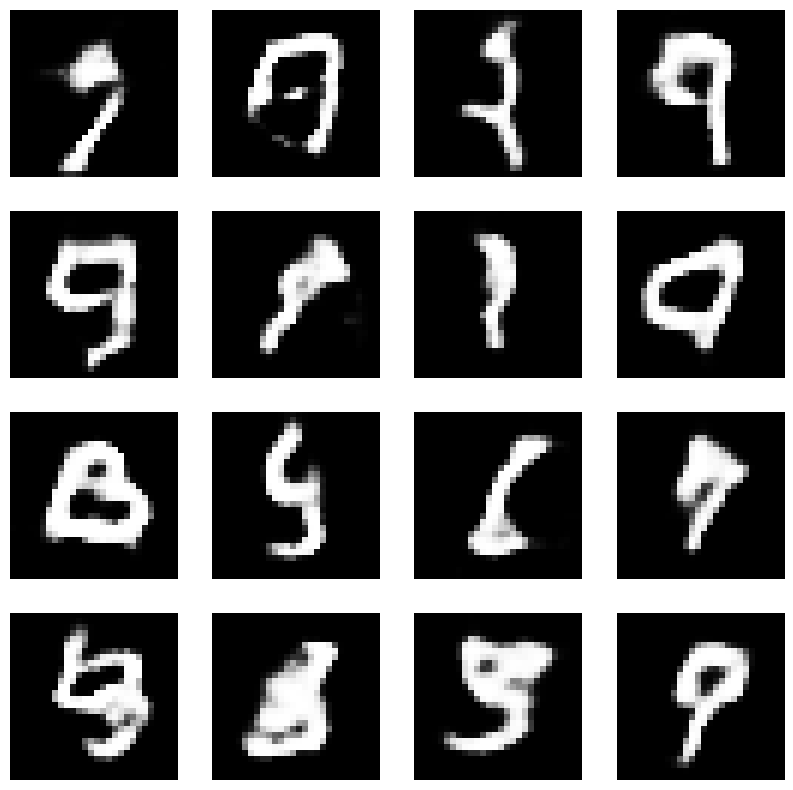

Epoch:  90


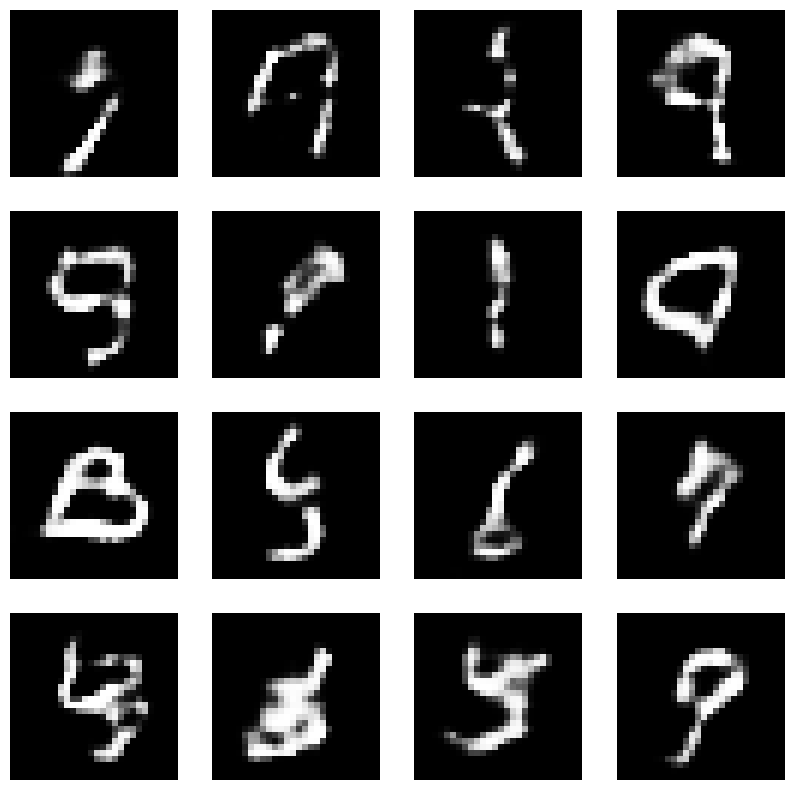

Epoch:  91


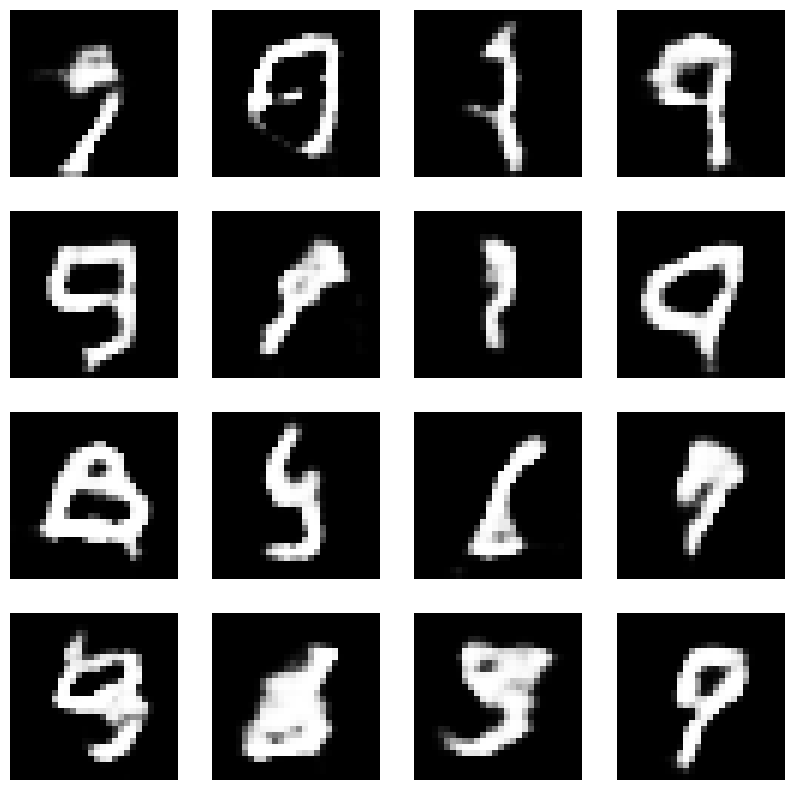

Epoch:  92


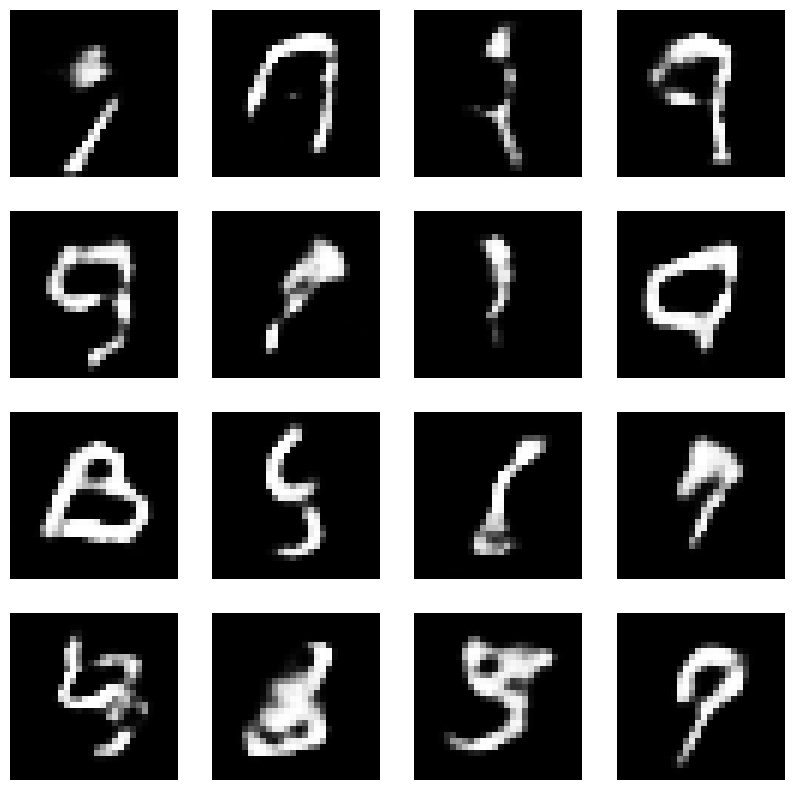

Epoch:  93


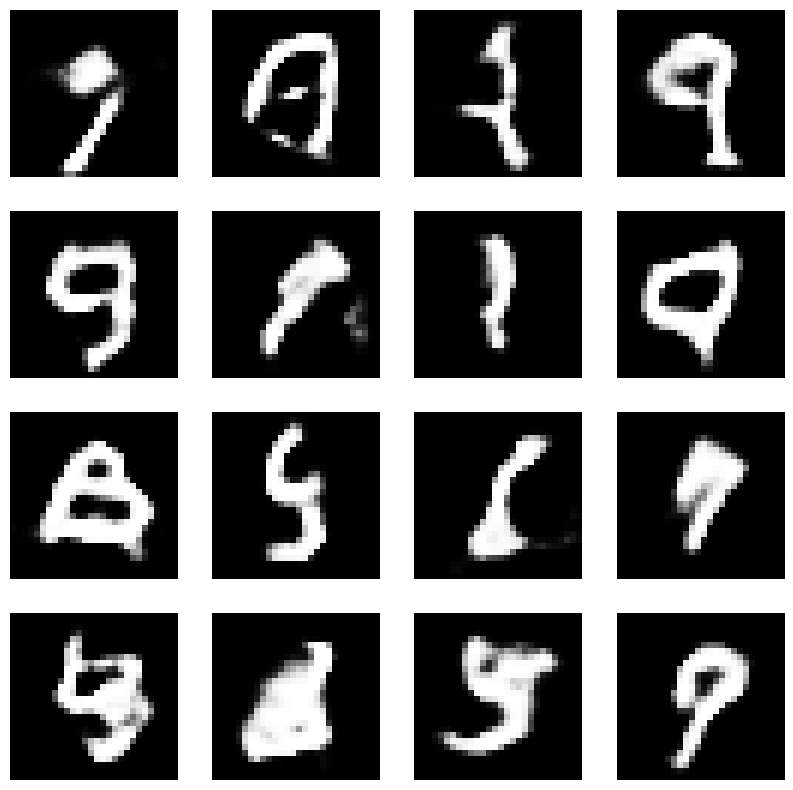

Epoch:  94


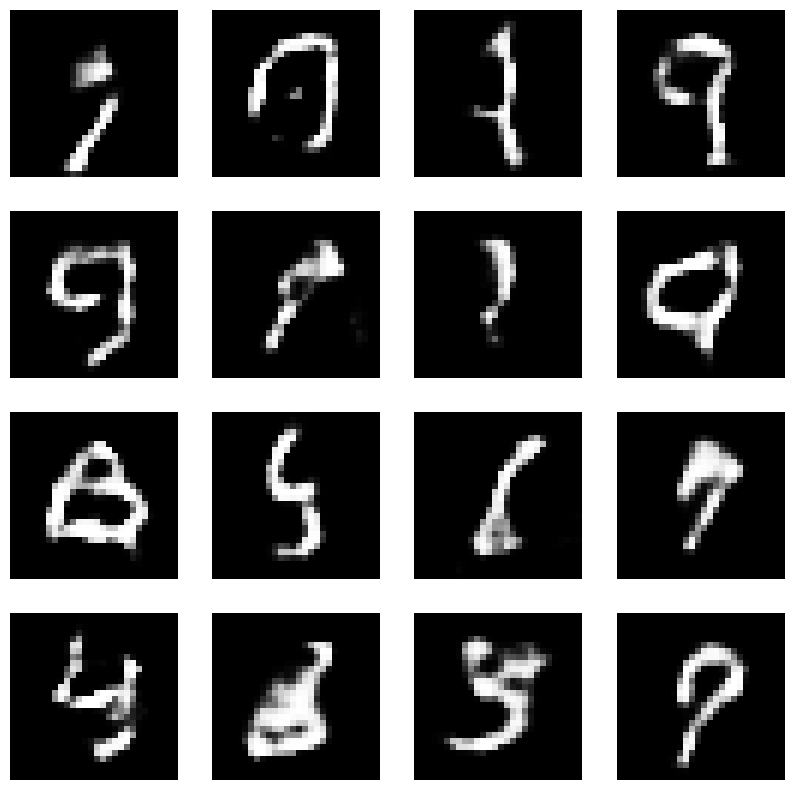

Epoch:  95


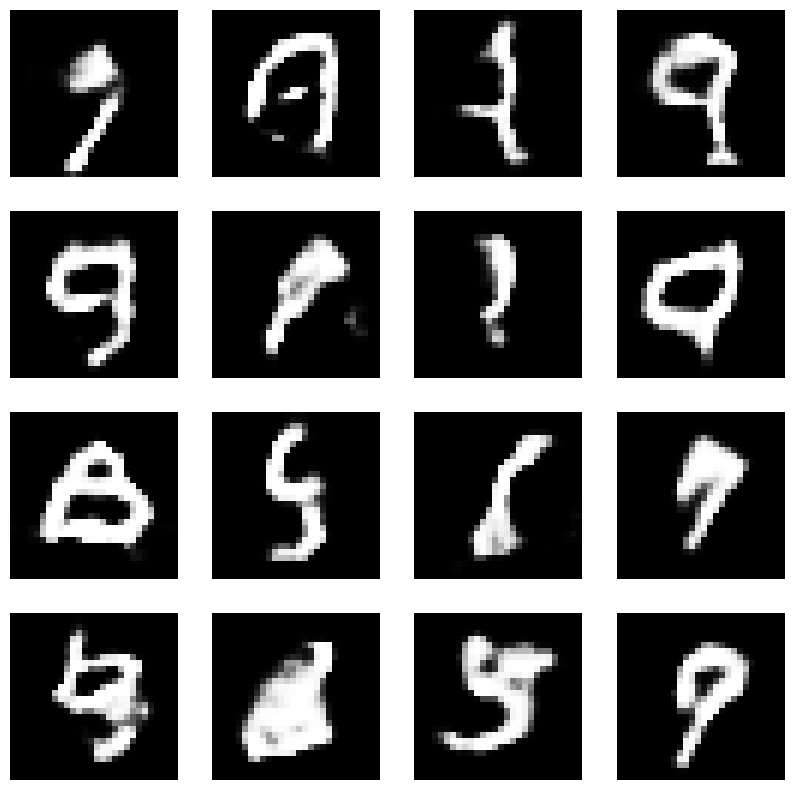

Epoch:  96


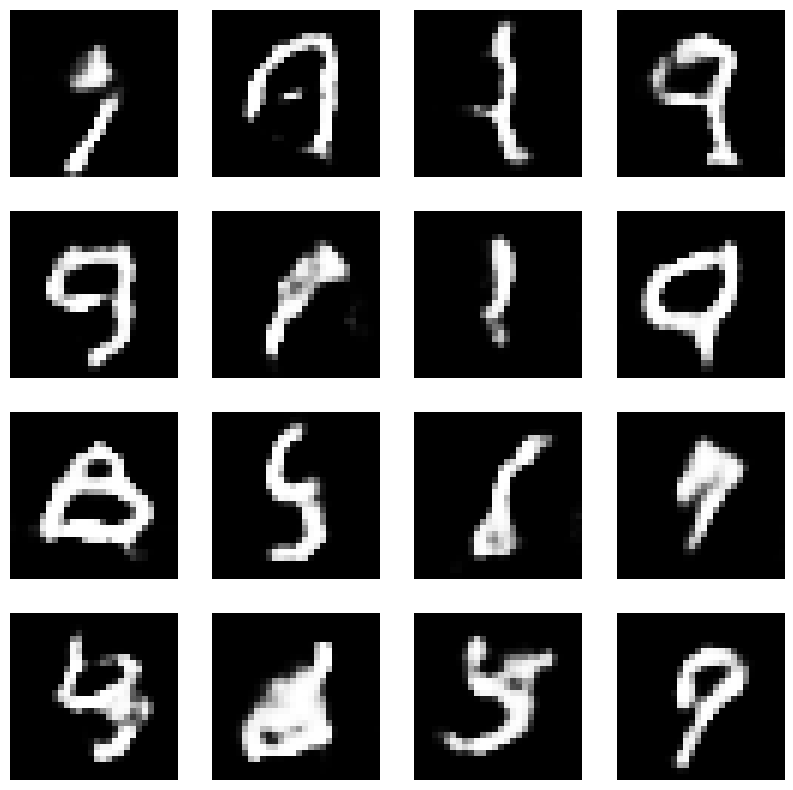

Epoch:  97


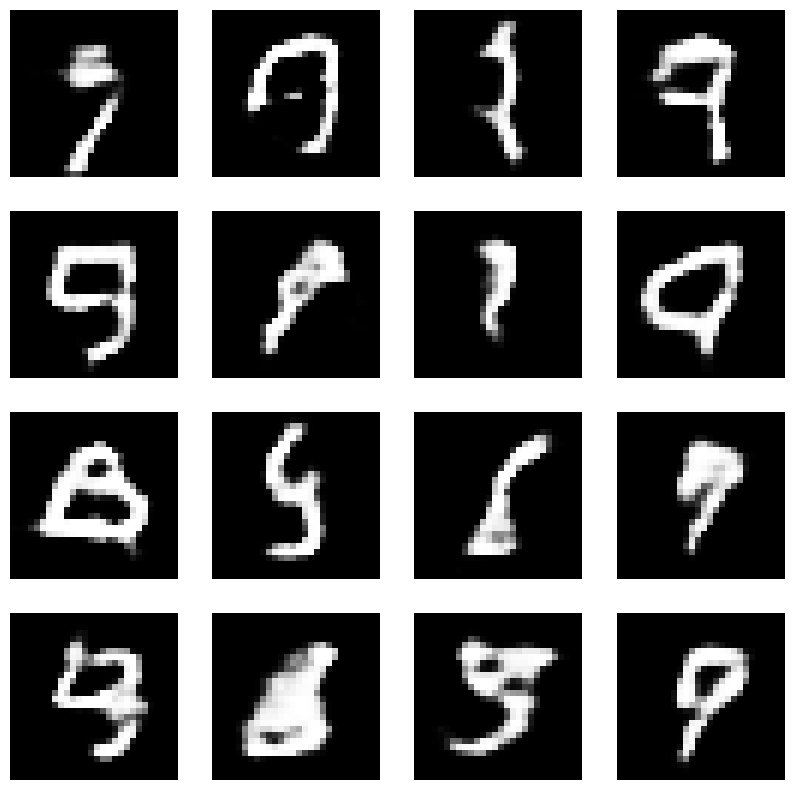

Epoch:  98


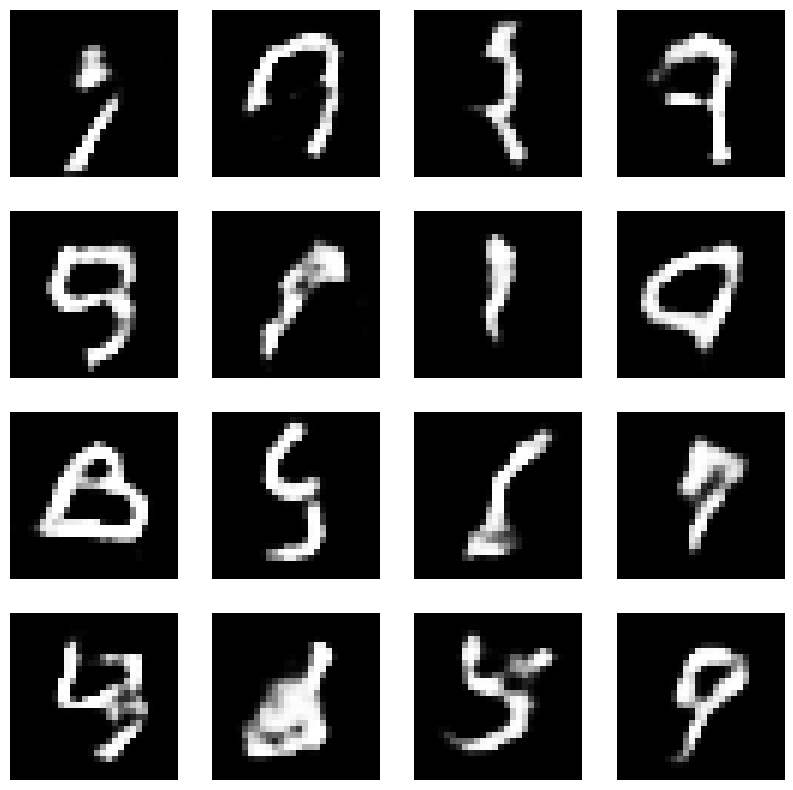

Epoch:  99


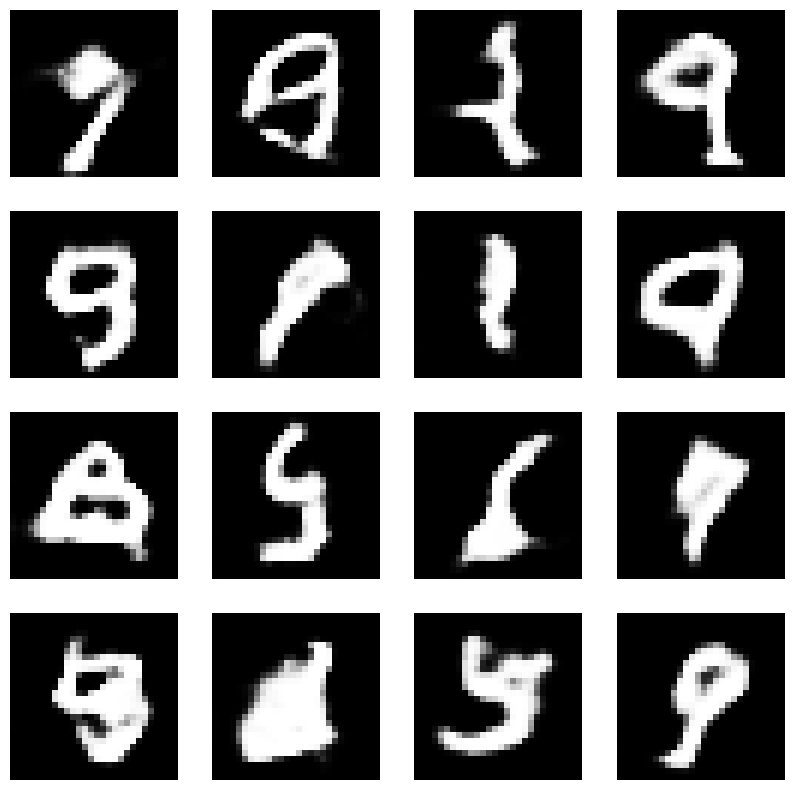

Epoch:  100


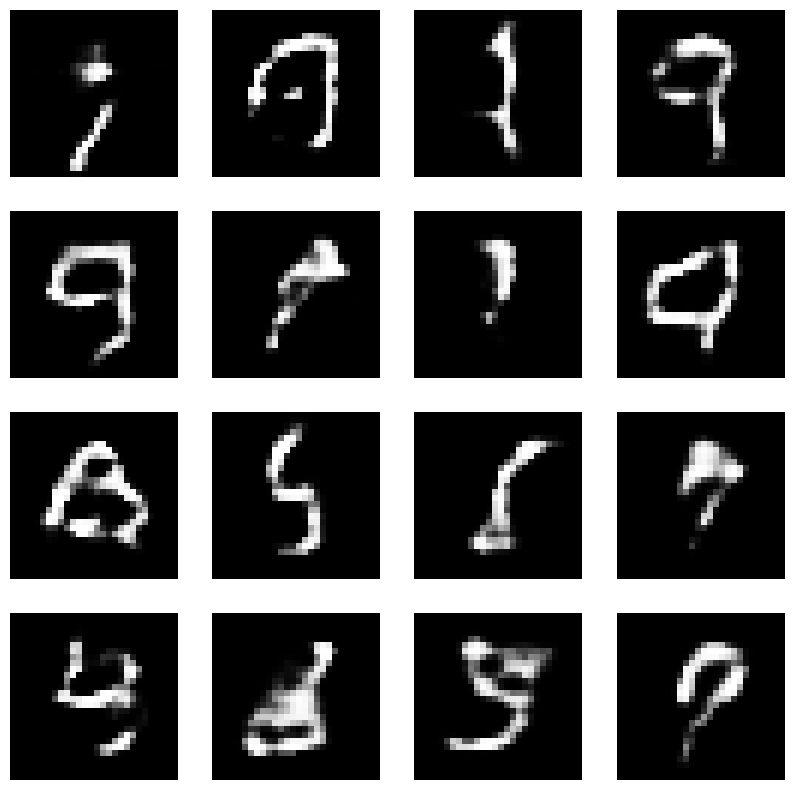

In [ ]:
train_gan(X_train, EPOCHS, test_images)